In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import re
import io
from collections import Counter
from tqdm import tqdm
from time import time
import nltk
nltk.download('stopwords')
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, metrics, utils, applications, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# reading the data
data = pd.read_csv('emails.csv')
data.head()   #print head

# For removing stopwords from the text (replacing it with '')
from nltk.corpus import stopwords
stopwords_eng = set(stopwords.words('english'))
def remove_stopwords(txt):
    for stopword in stopwords_eng:
        while stopword in txt:
            txt = txt.replace(stopword,'')
    return txt

# splitting Training, testing and validation data in the ratio 8:1:1
from sklearn.model_selection import train_test_split as tts
def data_set_split(X, y, split_sizes=[8,1,1], stratify=True):  #stratify to ensure balanced class distribution
    split_sizes = np.array(split_sizes)
    if stratify:
        train_X, test_X, train_y, test_y = tts(X, y, test_size=split_sizes[2]/split_sizes.sum(), stratify=y)
        train_X, val_X, train_y, val_y = tts(train_X, train_y, test_size=split_sizes[1]/(split_sizes[0]+split_sizes[1]), stratify=train_y)
    else:
        train_X, test_X, train_y, test_y = tts(X, y, test_size=split_sizes[2]/split_sizes.sum())
        train_X, val_X, train_y, val_y = tts(train_X, train_y, test_size=split_sizes[1]/(split_sizes[0]+split_sizes[1]))
    return train_X, val_X, test_X, train_y, val_y, test_y


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(data.message[0])


Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [ ]:
sender_pattern = re.compile('(?<=From:\s).*') # extract the sender of the message
xfile_pattern = re.compile('X-FileName:.*') #extract the file name
content_pattern = re.compile('[^\n].*\Z', re.S)  #extract the content of the mail. re.S flag used to match '.' to newline

xfile_end = xfile_pattern.search(data.message[0]).end()
content = content_pattern.search(data.message[0], pos=xfile_end)  # content after Xfilename is stored in content

print(data.message[0])
print(sender_pattern.search(data.message[0]).group())
print("Message:")
print(content.group())


Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 
phillip.allen@enron.com
Message:
Here is our forecast

 


In [ ]:
data['Sender'] = data.message.apply(lambda x: sender_pattern.search(x).group()) #add a sender column and populate it using sender_pattern function
data['Content'] = data.message.apply(
    lambda x: content_pattern.search( x, pos = xfile_pattern.search(x).end()).group())   # add a Content column
data['Length'] = data.Content.apply(lambda x: len(x)) #add a Length column denoting the length of the message

print(data.isnull().any())  #checking if our columns have any null values (improper column formation)
data.head()




file       False
message    False
Sender     False
Content    False
Length     False
dtype: bool


,file,message,Sender,Content,Length
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,phillip.allen@enron.com,Here is our forecast\n\n,23
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,phillip.allen@enron.com,Traveling to have a business meeting takes the...,786
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,phillip.allen@enron.com,test successful. way to go!!!,30
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,phillip.allen@enron.com,"Randy,\n\n Can you send me a schedule of the s...",187
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,phillip.allen@enron.com,Let's shoot for Tuesday at 11:45.,35


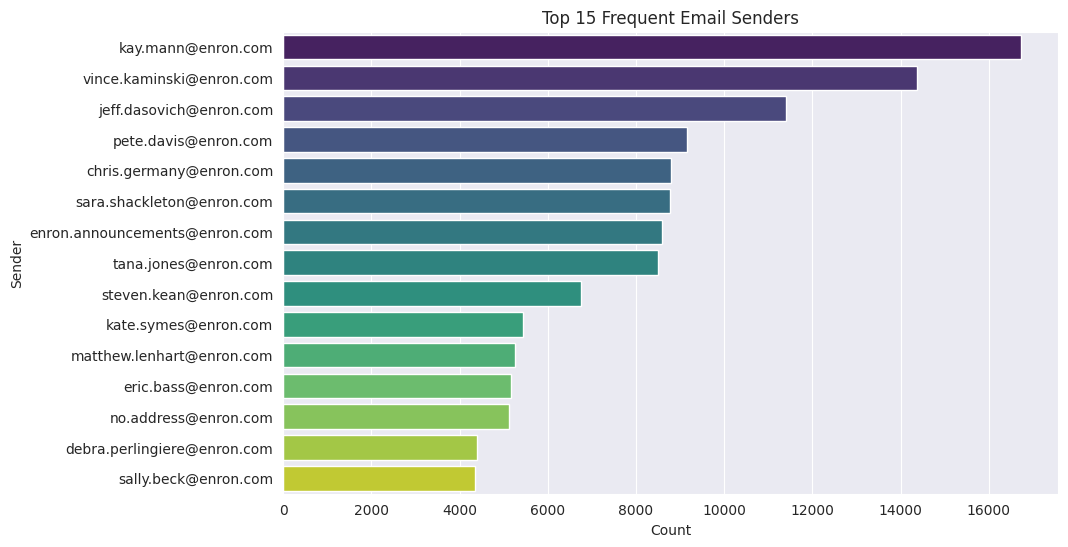

In [ ]:
data.Sender.value_counts()[:15] #extract top 15 frequent email senders
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 15 frequent email senders
top_senders = data['Sender'].value_counts()[:15]

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=top_senders.values, y=top_senders.index, palette='viridis')
plt.title('Top 15 Frequent Email Senders')
plt.xlabel('Count')
plt.ylabel('Sender')
plt.show()



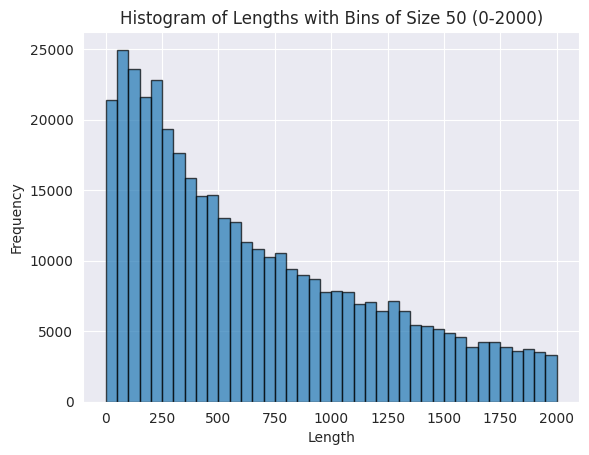

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'Length' column is already created in your DataFrame
# If not, make sure to create it using: data['Length'] = data['Content'].apply(len)

# Define bin edges based on the desired range and bin size
bin_edges = list(range(0, 2001, 50))

# Create bins and plot histogram
plt.hist(data['Length'], bins=bin_edges, edgecolor='black', alpha=0.7)

# Set labels and title
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Lengths with Bins of Size 50 (0-2000)')

# Show the plot
plt.show()


prepare model for classification

In [ ]:
senders_list = data.Sender.value_counts().index[:15].tolist() # Find Top 15 senders
messages_per_class = 1024  #sample random 1024 messages of each sender

texts = [] # preprocessed content of the emails will be stored here
labels = [] # corresponding labels (sender indices) will be stored.
for i, sender in tqdm(enumerate(senders_list)):
    sender_texts = data.query(' `Sender` == @sender ').sample(frac=1)['Content'][:messages_per_class].apply(lambda x: remove_stopwords(x)).values.tolist() #extract the content of 1024 messages from each sender
    texts += sender_texts
    labels += (np.ones(shape=(messages_per_class,))*i).tolist()


15it [00:07,  1.99it/s]


In [ ]:
max_words = 512   #512 Maximum number of words the model will learn. depends on the diversity of vocabulary
embed_dim = 128      #128 Number of embedding dimensions. to capture complex relationships between words
maxlen =  512        #The length of the message - The longer messages will be cropped to 512, shorter ones will be padded with zeros


tokenizer = Tokenizer(num_words=max_words) # seperate each word into tokens
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

seqs = tokenizer.texts_to_sequences(texts) # convert words into sequences of integers corresponding to 512 most freq words
seqs = pad_sequences(seqs, maxlen=maxlen) # pad sequence to make it 512 tokens long

labels = np.array(labels)

train_X, val_X, test_X, train_y, val_y, test_y = data_set_split(seqs, labels, stratify=True) # split sequences into training, validation and testing sets in 8:1:1

In [ ]:
# ensure equal distribution of classes
for X, y in [train_X, train_y], [val_X, val_y], [test_X, test_y]:
    print(X.shape, y.shape)
    print(np.bincount(y.astype(np.int32)))

(12288, 512) (12288,)
[819 819 819 820 819 820 819 819 819 819 819 819 819 819 820]
(1536, 512) (1536,)
[103 102 102 102 103 102 102 103 102 102 103 103 102 103 102]
(1536, 512) (1536,)
[102 103 103 102 102 102 103 102 103 103 102 102 103 102 102]


#**Build and train models.**


Naive Bayes (baseline)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Use CountVectorizer to convert text data into a bag-of-words representation
vectorizer = CountVectorizer(max_features=max_words)
X = vectorizer.fit_transform(texts).toarray()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
baseline_model = MultinomialNB()
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = baseline_model.predict(X_test)

# Evaluate the baseline model
accuracy = accuracy_score(y_test, predictions)
print(f"Baseline Model Accuracy: {accuracy:.2%}")

# Display additional classification metrics
print(classification_report(y_test, predictions, target_names=senders_list))

Baseline Model Accuracy: 68.75%
                               precision    recall  f1-score   support

           kay.mann@enron.com       0.65      0.70      0.67       207
     vince.kaminski@enron.com       0.77      0.89      0.83       195
      jeff.dasovich@enron.com       0.53      0.65      0.58       210
         pete.davis@enron.com       1.00      1.00      1.00       219
      chris.germany@enron.com       0.80      0.63      0.71       212
    sara.shackleton@enron.com       0.79      0.67      0.72       209
enron.announcements@enron.com       0.45      0.83      0.58       183
         tana.jones@enron.com       0.76      0.60      0.67       202
        steven.kean@enron.com       0.71      0.64      0.68       211
         kate.symes@enron.com       0.63      0.86      0.73       222
    matthew.lenhart@enron.com       0.49      0.32      0.39       194
          eric.bass@enron.com       0.67      0.66      0.66       195
         no.address@enron.com       0.76    

#LSTM


In [ ]:
import tensorflow as tf
from keras.layers import Bidirectional, LSTM, Dense, Embedding, Dropout

# Define the model architecture
modelLSTM = tf.keras.Sequential([
    # Embedding layer to convert words into vectors
    Embedding(input_dim=max_words, output_dim=embed_dim, input_length=maxlen),

    # Bidirectional LSTM layer to learn temporal dependencies in the text
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Bidirectional(LSTM(units=32)),

    # Dropout layer to prevent overfitting
    Dropout(rate=0.2),

    # Dense layer to learn a mapping from the LSTM output to the class labels
    Dense(units=15, activation='softmax')  # Adjust the number of units to match the number of classes
])

# Compile the model
modelLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.utils import to_categorical

def learningRate_scheduler(epoch, lr):
    if epoch==8 or epoch==12:
        return lr/8
    else:
        return lr


callbacks_list = [
    callbacks.ModelCheckpoint('best_modelLSTM.h5', monitor='val_loss', save_best_only=True, save_freq='epoch'),
    callbacks.LearningRateScheduler(learningRate_scheduler)
]

modelLSTM.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

EPOCHS = 16

train_y_one_hot = to_categorical(train_y, num_classes=15)
val_y_one_hot = to_categorical(val_y, num_classes=15)

historyLSTM = modelLSTM.fit(
    train_X, train_y_one_hot,
    validation_data=(val_X, val_y_one_hot),
    epochs=EPOCHS, batch_size=64,

    shuffle=True,
    verbose=1,
    callbacks=callbacks_list
)


pd.DataFrame(historyLSTM.history).to_csv('historyLSTM.csv')
modelLSTM.save('last_modelLSTM.h5')

Epoch 1/16
192/192 [==============================] - 311s 2s/step - loss: 0.2734 - acc: 0.0662 - val_loss: 0.2451 - val_acc: 0.0651 - lr: 0.0010
Epoch 2/16


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/192 [==========================>...] - ETA: 22s - loss: 0.2487 - acc: 0.0696

In [ ]:
train_loss = historyLSTM.history['loss']
val_loss = historyLSTM.history['val_loss']

train_acc = historyLSTM.history['acc']
val_acc = historyLSTM.history['val_acc']

lr = historyLSTM.history['lr']

x = np.arange(1, EPOCHS+1)

#compares training and validation loss across all epochs
plt.plot(x, train_loss, 'b--', label='Training loss')
plt.plot(x, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#compares training and validation accuracy across all epochs
plt.plot(x, train_acc, 'b--', label='Training accuracy')
plt.plot(x, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

#plots the learning rate showing change after 8th and 12th epochs
plt.plot(x, lr, 'g-', label='Learning Rate')
plt.yscale('log')
plt.title('Learning rate')
plt.legend()
plt.show()

In [ ]:
modelLSTM.load_weights('last_modelLSTM.h5')
modelLSTM.compile(        #last model
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\t\tLAST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(test_X, test_y, verbose=0)))

best_modelLSTM = models.load_model('best_modelLSTM.h5')
best_modelLSTM.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\n\t\tBEST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelLSTM.evaluate(test_X, test_y, verbose=0)))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming predictions are obtained using modelCNN.predict()

predictions = modelLSTM.predict(test_X)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')

print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1)

#CNN

In [ ]:
from tensorflow.keras import Sequential
modelCNN = Sequential()

# Embedding layer to convert words into vectors
modelCNN.add(layers.Embedding(input_dim=max_words, output_dim=embed_dim, input_length=maxlen))

# Convolutional layers to extract local patterns from the word vectors
modelCNN.add(layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
modelCNN.add(layers.MaxPooling1D(pool_size=2))
modelCNN.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
modelCNN.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output of the convolutional layers into a 1D vector
modelCNN.add(layers.Flatten())

# Fully connected layers to learn higher-level features from the flattened output
modelCNN.add(layers.Dense(units=64, activation='relu', kernel_regularizer='l2'))
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.Dropout(rate=0.2))
modelCNN.add(layers.Dense(units=32, activation='relu', kernel_regularizer='l2'))
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.Dropout(rate=0.1))

# Output layer with softmax activation for multi-class classification
modelCNN.add(layers.Dense(units=15, activation='softmax'))  # Adjust the number of units to match the number of classes

# Compile the modelCNN
modelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
def learningRate_scheduler(epoch, lr):
    if epoch==8 or epoch==12:
        return lr/8
    else:
        return lr


callbacks_list = [
    callbacks.ModelCheckpoint('best_modelCNN.h5', monitor='val_loss', save_best_only=True, save_freq='epoch'),
    callbacks.LearningRateScheduler(learningRate_scheduler)
]

modelCNN.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

EPOCHS = 16

historyCNN = modelCNN.fit(
    train_X, train_y,
    validation_data = (val_X, val_y),
    epochs = EPOCHS, batch_size=64,
    shuffle = True,
    verbose = 1,
    callbacks = callbacks_list
)

pd.DataFrame(historyCNN.history).to_csv('historyCNN.csv')
modelCNN.save('last_modelCNN.h5')

Epoch 1/16
192/192 [==============================] - 29s 142ms/step - loss: 0.6616 - acc: 0.8109 - val_loss: 1.3057 - val_acc: 0.7240 - lr: 0.0010
Epoch 2/16
  1/192 [..............................] - ETA: 20s - loss: 0.5671 - acc: 0.7969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - 26s 133ms/step - loss: 0.8031 - acc: 0.7576 - val_loss: 6.3824 - val_acc: 0.2448 - lr: 0.0010
Epoch 3/16
192/192 [==============================] - 25s 129ms/step - loss: 0.7454 - acc: 0.7777 - val_loss: 1.2174 - val_acc: 0.7122 - lr: 0.0010
Epoch 4/16
192/192 [==============================] - 24s 126ms/step - loss: 0.6998 - acc: 0.7904 - val_loss: 2.1314 - val_acc: 0.5358 - lr: 0.0010
Epoch 5/16
192/192 [==============================] - 26s 133ms/step - loss: 0.6853 - acc: 0.7975 - val_loss: 6.6521 - val_acc: 0.3086 - lr: 0.0010
Epoch 6/16
192/192 [==============================] - 26s 133ms/step - loss: 0.9167 - acc: 0.7074 - val_loss: 2.0106 - val_acc: 0.5456 - lr: 0.0010
Epoch 7/16
192/192 [==============================] - 24s 126ms/step - loss: 0.8266 - acc: 0.7405 - val_loss: 1.5719 - val_acc: 0.6009 - lr: 0.0010
Epoch 8/16
192/192 [==============================] - 24s 127ms/step - loss: 0.8143 - acc: 0.7463 - val_loss: 1.3649 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_loss = historyCNN.history['loss']
val_loss = historyCNN.history['val_loss']

train_acc = historyCNN.history['acc']
val_acc = historyCNN.history['val_acc']

lr = historyCNN.history['lr']

x = np.arange(1, EPOCHS+1)

#compares training and validation loss across all epochs
plt.plot(x, train_loss, 'b--', label='Training loss')
plt.plot(x, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#compares training and validation accuracy across all epochs
plt.plot(x, train_acc, 'b--', label='Training accuracy')
plt.plot(x, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

#plots the learning rate showing change after 8th and 12th epochs
plt.plot(x, lr, 'g-', label='Learning Rate')
plt.yscale('log')
plt.title('Learning rate')
plt.legend()
plt.show()

In [ ]:
modelCNN.load_weights('last_modelCNN.h5')
modelCNN.compile(        #last model
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\t\tLAST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelCNN.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelCNN.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelCNN.evaluate(test_X, test_y, verbose=0)))

best_modelCNN = models.load_model('best_modelCNN.h5')
best_modelCNN.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\n\t\tBEST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_modelCNN.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_modelCNN.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_modelCNN.evaluate(test_X, test_y, verbose=0)))

		LAST MODEL:
Training set metrics:	Loss: 0.2033	Accuracy: 0.9753
Validation set metrics:	Loss: 0.7708	Accuracy: 0.8132
Testing set metrics:		Loss: 0.6962	Accuracy: 0.8392

		BEST MODEL:
Training set metrics:	Loss: 0.2030	Accuracy: 0.9757
Validation set metrics:	Loss: 0.7620	Accuracy: 0.8216
Testing set metrics:		Loss: 0.6885	Accuracy: 0.8418


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming predictions are obtained using modelCNN.predict()

predictions = modelCNN.predict(test_X)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')

print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1)


48/48 [==============================] - 1s 20ms/step
Precision: 0.8529
Recall: 0.8392
F1 Score: 0.8429


#Bidirectional GRU

In [ ]:
modelGRU = models.Sequential(layers=[
    layers.Embedding(input_dim=max_words, output_dim=embed_dim, input_length=maxlen),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=True, dropout=.1, recurrent_dropout=.1)),
    layers.Bidirectional(layers.GRU(32, activation='relu', return_sequences=False, dropout=.1, recurrent_dropout=.1)),
    layers.Dense(64, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.2),
    layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    layers.BatchNormalization(),
    layers.Dropout(.1),
    layers.Dense(15, activation='softmax')      #number of classes
])
#modelGRU.summary()

In [ ]:
def learningRate_scheduler(epoch, lr):
    if epoch==8 or epoch==12:
        return lr/8
    else:
        return lr


callbacks_list = [
    callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_freq='epoch'),
    callbacks.LearningRateScheduler(learningRate_scheduler)
]

modelGRU.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

EPOCHS = 16

historyGRU = modelGRU.fit(
    train_X, train_y,
    validation_data = (val_X, val_y),
    epochs = EPOCHS, batch_size=64,
    shuffle = True,
    verbose = 1,
    callbacks = callbacks_list
)

pd.DataFrame(historyGRU.history).to_csv('historyGRU.csv')
modelGRU.save('last_modelGRU.h5')

Epoch 1/16
192/192 [==============================] - 443s 2s/step - loss: 2.7097 - acc: 0.3457 - val_loss: 2.9721 - val_acc: 0.0690 - lr: 0.0010
Epoch 2/16


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


192/192 [==============================] - 414s 2s/step - loss: 1.9287 - acc: 0.4718 - val_loss: 2.5930 - val_acc: 0.2337 - lr: 0.0010
Epoch 3/16
192/192 [==============================] - 401s 2s/step - loss: 1.6776 - acc: 0.5255 - val_loss: 1.8470 - val_acc: 0.5052 - lr: 0.0010
Epoch 4/16
192/192 [==============================] - 406s 2s/step - loss: 1.5094 - acc: 0.5688 - val_loss: 1.5860 - val_acc: 0.5339 - lr: 0.0010
Epoch 5/16
192/192 [==============================] - 415s 2s/step - loss: 1.3151 - acc: 0.6247 - val_loss: 1.2746 - val_acc: 0.6406 - lr: 0.0010
Epoch 6/16
192/192 [==============================] - 404s 2s/step - loss: 1.0328 - acc: 0.7112 - val_loss: 2.2141 - val_acc: 0.4525 - lr: 0.0010
Epoch 7/16
192/192 [==============================] - 411s 2s/step - loss: 0.7822 - acc: 0.7971 - val_loss: 0.8228 - val_acc: 0.7845 - lr: 0.0010
Epoch 8/16
192/192 [==============================] - 424s 2s/step - loss: 0.6222 - acc: 0.8417 - val_loss: 0.7782 - val_acc: 0.7982 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_loss = historyGRU.history['loss']
val_loss = historyGRU.history['val_loss']

train_acc = historyGRU.history['acc']
val_acc = historyGRU.history['val_acc']

lr = historyGRU.history['lr']

x = np.arange(1, EPOCHS+1)

#compares training and validation loss across all epochs
plt.plot(x, train_loss, 'b--', label='Training loss')
plt.plot(x, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#compares training and validation accuracy across all epochs
plt.plot(x, train_acc, 'b--', label='Training accuracy')
plt.plot(x, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

#plots the learning rate showing change after 8th and 12th epochs
plt.plot(x, lr, 'g-', label='Learning Rate')
plt.yscale('log')
plt.title('Learning rate')
plt.legend()
plt.show()

In [ ]:
modelGRU.load_weights('last_modelGRU.h5')
modelGRU.compile(        #last model
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\t\tLAST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelGRU.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelGRU.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(modelGRU.evaluate(test_X, test_y, verbose=0)))

best_model = models.load_model('best_model.h5')
best_model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)
print("\n\t\tBEST MODEL:")
print('Training set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_model.evaluate(train_X, train_y, verbose=0)))
print('Validation set metrics:\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_model.evaluate(val_X, val_y, verbose=0)))
print('Testing set metrics:\t\tLoss: %.4f\tAccuracy: %.4f' % tuple(best_model.evaluate(test_X, test_y, verbose=0)))

		LAST MODEL:
Training set metrics:	Loss: 0.3419	Accuracy: 0.9160
Validation set metrics:	Loss: 0.5107	Accuracy: 0.8763
Testing set metrics:		Loss: 0.4617	Accuracy: 0.8900

		BEST MODEL:
Training set metrics:	Loss: 0.3419	Accuracy: 0.9160
Validation set metrics:	Loss: 0.5107	Accuracy: 0.8763
Testing set metrics:		Loss: 0.4617	Accuracy: 0.8900


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming predictions are obtained using modelCNN.predict()

predictions = modelGRU.predict(test_X)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(test_y, predicted_labels, average='weighted')
recall = recall_score(test_y, predicted_labels, average='weighted')
f1 = f1_score(test_y, predicted_labels, average='weighted')

print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1)


48/48 [==============================] - 13s 239ms/step
Precision: 0.8940
Recall: 0.8900
F1 Score: 0.8910


In [ ]:
cm = np.zeros(shape=(15,15))

for X, y in tqdm(zip(test_X, test_y)):
    pred = modelGRU.predict(X.reshape(1,-1)).argmax().astype(np.int32)
    y = int(y)
    cm[pred,y] += 1

0it [00:00, ?it/s]

1/1 [==============================] - 4s 4s/step


1it [00:04,  4.49s/it]

1/1 [==============================] - 1s 742ms/step


2it [00:05,  2.37s/it]

1/1 [==============================] - 1s 518ms/step


3it [00:06,  1.62s/it]

1/1 [==============================] - 0s 472ms/step


4it [00:06,  1.24s/it]

1/1 [==============================] - 0s 321ms/step


5it [00:07,  1.07it/s]

1/1 [==============================] - 0s 277ms/step


6it [00:07,  1.36it/s]

1/1 [==============================] - 0s 455ms/step


7it [00:08,  1.48it/s]

1/1 [==============================] - 0s 441ms/step


8it [00:08,  1.51it/s]

1/1 [==============================] - 0s 170ms/step


9it [00:08,  1.84it/s]

1/1 [==============================] - 0s 178ms/step


10it [00:09,  2.24it/s]

1/1 [==============================] - 0s 165ms/step


11it [00:09,  2.67it/s]

1/1 [==============================] - 0s 143ms/step


12it [00:09,  3.11it/s]

1/1 [==============================] - 0s 134ms/step


13it [00:09,  3.56it/s]

1/1 [==============================] - 0s 137ms/step


14it [00:09,  3.98it/s]

1/1 [==============================] - 0s 138ms/step


15it [00:10,  4.31it/s]

1/1 [==============================] - 0s 174ms/step


16it [00:10,  4.36it/s]

1/1 [==============================] - 0s 173ms/step


17it [00:10,  4.41it/s]

1/1 [==============================] - 0s 168ms/step


18it [00:10,  4.44it/s]

1/1 [==============================] - 0s 173ms/step


19it [00:11,  4.47it/s]

1/1 [==============================] - 0s 174ms/step


20it [00:11,  4.48it/s]

1/1 [==============================] - 0s 132ms/step


21it [00:11,  4.69it/s]

1/1 [==============================] - 0s 137ms/step


22it [00:11,  4.89it/s]

1/1 [==============================] - 0s 165ms/step


23it [00:11,  4.79it/s]

1/1 [==============================] - 0s 169ms/step


24it [00:12,  4.73it/s]

1/1 [==============================] - 0s 147ms/step


25it [00:12,  4.83it/s]

1/1 [==============================] - 0s 164ms/step


26it [00:12,  4.78it/s]

1/1 [==============================] - 0s 167ms/step


27it [00:12,  4.76it/s]

1/1 [==============================] - 0s 135ms/step


28it [00:12,  4.95it/s]

1/1 [==============================] - 0s 240ms/step


29it [00:13,  4.30it/s]

1/1 [==============================] - 0s 249ms/step


30it [00:13,  3.84it/s]

1/1 [==============================] - 0s 301ms/step


31it [00:13,  3.41it/s]

1/1 [==============================] - 0s 314ms/step


32it [00:14,  3.11it/s]

1/1 [==============================] - 0s 278ms/step


33it [00:14,  3.05it/s]

1/1 [==============================] - 0s 250ms/step


34it [00:14,  3.09it/s]

1/1 [==============================] - 0s 259ms/step


35it [00:15,  3.02it/s]

1/1 [==============================] - 0s 269ms/step


36it [00:15,  3.00it/s]

1/1 [==============================] - 0s 250ms/step


37it [00:15,  3.03it/s]

1/1 [==============================] - 0s 260ms/step


38it [00:16,  3.04it/s]

1/1 [==============================] - 0s 252ms/step


39it [00:16,  3.03it/s]

1/1 [==============================] - 0s 245ms/step


40it [00:16,  3.07it/s]

1/1 [==============================] - 0s 245ms/step


41it [00:17,  3.10it/s]

1/1 [==============================] - 0s 138ms/step


42it [00:17,  3.54it/s]

1/1 [==============================] - 0s 137ms/step


43it [00:17,  3.91it/s]

1/1 [==============================] - 0s 140ms/step


44it [00:17,  4.25it/s]

1/1 [==============================] - 0s 151ms/step


45it [00:17,  4.46it/s]

1/1 [==============================] - 0s 143ms/step


46it [00:18,  4.67it/s]

1/1 [==============================] - 0s 162ms/step


47it [00:18,  4.66it/s]

1/1 [==============================] - 0s 177ms/step


48it [00:18,  4.52it/s]

1/1 [==============================] - 0s 139ms/step


49it [00:18,  4.72it/s]

1/1 [==============================] - 0s 149ms/step


50it [00:19,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


51it [00:19,  4.91it/s]

1/1 [==============================] - 0s 167ms/step


52it [00:19,  4.83it/s]

1/1 [==============================] - 0s 136ms/step


53it [00:19,  4.97it/s]

1/1 [==============================] - 0s 133ms/step


54it [00:19,  5.11it/s]

1/1 [==============================] - 0s 155ms/step


55it [00:20,  5.05it/s]

1/1 [==============================] - 0s 133ms/step


56it [00:20,  5.16it/s]

1/1 [==============================] - 0s 145ms/step


57it [00:20,  5.06it/s]

1/1 [==============================] - 0s 141ms/step


58it [00:20,  5.15it/s]

1/1 [==============================] - 0s 148ms/step


59it [00:20,  5.14it/s]

1/1 [==============================] - 0s 180ms/step


60it [00:21,  4.87it/s]

1/1 [==============================] - 0s 153ms/step


61it [00:21,  4.88it/s]

1/1 [==============================] - 0s 176ms/step


62it [00:21,  4.74it/s]

1/1 [==============================] - 0s 178ms/step


63it [00:21,  4.62it/s]

1/1 [==============================] - 0s 134ms/step


64it [00:21,  4.86it/s]

1/1 [==============================] - 0s 151ms/step


65it [00:22,  4.92it/s]

1/1 [==============================] - 0s 134ms/step


66it [00:22,  4.94it/s]

1/1 [==============================] - 0s 137ms/step


67it [00:22,  5.08it/s]

1/1 [==============================] - 0s 170ms/step


68it [00:22,  4.90it/s]

1/1 [==============================] - 0s 132ms/step


69it [00:22,  5.06it/s]

1/1 [==============================] - 0s 152ms/step


70it [00:23,  5.00it/s]

1/1 [==============================] - 0s 127ms/step


71it [00:23,  5.12it/s]

1/1 [==============================] - 0s 174ms/step


72it [00:23,  4.90it/s]

1/1 [==============================] - 0s 174ms/step


73it [00:23,  4.77it/s]

1/1 [==============================] - 0s 169ms/step


74it [00:23,  4.72it/s]

1/1 [==============================] - 0s 164ms/step


75it [00:24,  4.68it/s]

1/1 [==============================] - 0s 171ms/step


76it [00:24,  4.64it/s]

1/1 [==============================] - 0s 172ms/step


77it [00:24,  4.53it/s]

1/1 [==============================] - 0s 133ms/step


78it [00:24,  4.78it/s]

1/1 [==============================] - 0s 160ms/step


79it [00:24,  4.76it/s]

1/1 [==============================] - 0s 272ms/step


80it [00:25,  3.92it/s]

1/1 [==============================] - 0s 237ms/step


81it [00:25,  3.67it/s]

1/1 [==============================] - 0s 232ms/step


82it [00:25,  3.53it/s]

1/1 [==============================] - 0s 258ms/step


83it [00:26,  3.31it/s]

1/1 [==============================] - 0s 176ms/step


84it [00:26,  3.46it/s]

1/1 [==============================] - 0s 137ms/step


85it [00:26,  3.87it/s]

1/1 [==============================] - 0s 178ms/step


86it [00:26,  4.02it/s]

1/1 [==============================] - 0s 171ms/step


87it [00:27,  4.17it/s]

1/1 [==============================] - 0s 295ms/step


88it [00:27,  3.60it/s]

1/1 [==============================] - 0s 293ms/step


89it [00:27,  3.32it/s]

1/1 [==============================] - 0s 331ms/step


90it [00:28,  3.05it/s]

1/1 [==============================] - 0s 245ms/step


91it [00:28,  3.12it/s]

1/1 [==============================] - 0s 240ms/step


92it [00:28,  3.19it/s]

1/1 [==============================] - 0s 260ms/step


93it [00:29,  3.13it/s]

1/1 [==============================] - 0s 261ms/step


94it [00:29,  3.07it/s]

1/1 [==============================] - 0s 265ms/step


95it [00:29,  3.03it/s]

1/1 [==============================] - 0s 285ms/step


96it [00:30,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


97it [00:30,  3.01it/s]

1/1 [==============================] - 0s 218ms/step


98it [00:30,  3.16it/s]

1/1 [==============================] - 0s 227ms/step


99it [00:31,  3.22it/s]

1/1 [==============================] - 0s 292ms/step


100it [00:31,  3.09it/s]

1/1 [==============================] - 0s 170ms/step


101it [00:31,  3.40it/s]

1/1 [==============================] - 0s 169ms/step


102it [00:31,  3.67it/s]

1/1 [==============================] - 0s 169ms/step


103it [00:32,  3.91it/s]

1/1 [==============================] - 0s 170ms/step


104it [00:32,  4.07it/s]

1/1 [==============================] - 0s 172ms/step


105it [00:32,  4.18it/s]

1/1 [==============================] - 0s 170ms/step


106it [00:32,  4.28it/s]

1/1 [==============================] - 0s 149ms/step


107it [00:33,  4.51it/s]

1/1 [==============================] - 0s 172ms/step


108it [00:33,  4.53it/s]

1/1 [==============================] - 0s 172ms/step


109it [00:33,  4.53it/s]

1/1 [==============================] - 0s 139ms/step


110it [00:33,  4.76it/s]

1/1 [==============================] - 0s 162ms/step


111it [00:33,  4.69it/s]

1/1 [==============================] - 0s 169ms/step


112it [00:34,  4.67it/s]

1/1 [==============================] - 0s 171ms/step


113it [00:34,  4.63it/s]

1/1 [==============================] - 0s 161ms/step


114it [00:34,  4.66it/s]

1/1 [==============================] - 0s 177ms/step


115it [00:34,  4.56it/s]

1/1 [==============================] - 0s 166ms/step


116it [00:34,  4.59it/s]

1/1 [==============================] - 0s 178ms/step


117it [00:35,  4.53it/s]

1/1 [==============================] - 0s 182ms/step


118it [00:35,  4.46it/s]

1/1 [==============================] - 0s 140ms/step


119it [00:35,  4.61it/s]

1/1 [==============================] - 0s 134ms/step


120it [00:35,  4.74it/s]

1/1 [==============================] - 0s 143ms/step


121it [00:36,  4.86it/s]

1/1 [==============================] - 0s 136ms/step


122it [00:36,  4.98it/s]

1/1 [==============================] - 0s 145ms/step


123it [00:36,  5.03it/s]

1/1 [==============================] - 0s 146ms/step


124it [00:36,  5.01it/s]

1/1 [==============================] - 0s 126ms/step


125it [00:36,  5.17it/s]

1/1 [==============================] - 0s 170ms/step


126it [00:37,  4.95it/s]

1/1 [==============================] - 0s 172ms/step


127it [00:37,  4.82it/s]

1/1 [==============================] - 0s 166ms/step


128it [00:37,  4.75it/s]

1/1 [==============================] - 0s 163ms/step


129it [00:37,  4.63it/s]

1/1 [==============================] - 0s 177ms/step


130it [00:37,  4.55it/s]

1/1 [==============================] - 0s 152ms/step


131it [00:38,  4.68it/s]

1/1 [==============================] - 0s 141ms/step


132it [00:38,  4.83it/s]

1/1 [==============================] - 0s 136ms/step


133it [00:38,  5.00it/s]

1/1 [==============================] - 0s 139ms/step


134it [00:38,  5.04it/s]

1/1 [==============================] - 0s 172ms/step


135it [00:38,  4.87it/s]

1/1 [==============================] - 0s 170ms/step


136it [00:39,  4.72it/s]

1/1 [==============================] - 0s 134ms/step


137it [00:39,  4.92it/s]

1/1 [==============================] - 0s 152ms/step


138it [00:39,  4.84it/s]

1/1 [==============================] - 0s 135ms/step


139it [00:39,  4.94it/s]

1/1 [==============================] - 0s 165ms/step


140it [00:39,  4.82it/s]

1/1 [==============================] - 0s 169ms/step


141it [00:40,  4.74it/s]

1/1 [==============================] - 0s 134ms/step


142it [00:40,  4.93it/s]

1/1 [==============================] - 0s 134ms/step


143it [00:40,  5.06it/s]

1/1 [==============================] - 0s 140ms/step


144it [00:40,  5.07it/s]

1/1 [==============================] - 0s 169ms/step


145it [00:40,  4.92it/s]

1/1 [==============================] - 0s 145ms/step


146it [00:41,  4.99it/s]

1/1 [==============================] - 0s 177ms/step


147it [00:41,  4.74it/s]

1/1 [==============================] - 0s 184ms/step


148it [00:41,  4.60it/s]

1/1 [==============================] - 0s 238ms/step


149it [00:41,  4.07it/s]

1/1 [==============================] - 0s 248ms/step


150it [00:42,  3.74it/s]

1/1 [==============================] - 0s 261ms/step


151it [00:42,  3.48it/s]

1/1 [==============================] - 0s 306ms/step


152it [00:42,  3.14it/s]

1/1 [==============================] - 0s 288ms/step


153it [00:43,  3.03it/s]

1/1 [==============================] - 0s 239ms/step


154it [00:43,  3.07it/s]

1/1 [==============================] - 0s 294ms/step


155it [00:44,  2.93it/s]

1/1 [==============================] - 0s 260ms/step


156it [00:44,  2.91it/s]

1/1 [==============================] - 0s 247ms/step


157it [00:44,  2.98it/s]

1/1 [==============================] - 0s 234ms/step


158it [00:44,  2.98it/s]

1/1 [==============================] - 0s 275ms/step


159it [00:45,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


160it [00:45,  2.96it/s]

1/1 [==============================] - 0s 142ms/step


161it [00:45,  3.36it/s]

1/1 [==============================] - 0s 142ms/step


162it [00:46,  3.71it/s]

1/1 [==============================] - 0s 143ms/step


163it [00:46,  4.04it/s]

1/1 [==============================] - 0s 154ms/step


164it [00:46,  4.28it/s]

1/1 [==============================] - 0s 169ms/step


165it [00:46,  4.30it/s]

1/1 [==============================] - 0s 180ms/step


166it [00:46,  4.34it/s]

1/1 [==============================] - 0s 134ms/step


167it [00:47,  4.60it/s]

1/1 [==============================] - 0s 138ms/step


168it [00:47,  4.73it/s]

1/1 [==============================] - 0s 151ms/step


169it [00:47,  4.79it/s]

1/1 [==============================] - 0s 172ms/step


170it [00:47,  4.72it/s]

1/1 [==============================] - 0s 174ms/step


171it [00:47,  4.56it/s]

1/1 [==============================] - 0s 169ms/step


172it [00:48,  4.54it/s]

1/1 [==============================] - 0s 169ms/step


173it [00:48,  4.55it/s]

1/1 [==============================] - 0s 169ms/step


174it [00:48,  4.48it/s]

1/1 [==============================] - 0s 167ms/step


175it [00:48,  4.48it/s]

1/1 [==============================] - 0s 178ms/step


176it [00:49,  4.43it/s]

1/1 [==============================] - 0s 174ms/step


177it [00:49,  4.42it/s]

1/1 [==============================] - 0s 139ms/step


178it [00:49,  4.59it/s]

1/1 [==============================] - 0s 137ms/step


179it [00:49,  4.82it/s]

1/1 [==============================] - 0s 141ms/step


180it [00:49,  4.92it/s]

1/1 [==============================] - 0s 135ms/step


181it [00:50,  5.03it/s]

1/1 [==============================] - 0s 139ms/step


182it [00:50,  5.08it/s]

1/1 [==============================] - 0s 140ms/step


183it [00:50,  5.07it/s]

1/1 [==============================] - 0s 128ms/step


184it [00:50,  5.26it/s]

1/1 [==============================] - 0s 138ms/step


185it [00:50,  5.19it/s]

1/1 [==============================] - 0s 143ms/step


186it [00:51,  5.10it/s]

1/1 [==============================] - 0s 136ms/step


187it [00:51,  5.10it/s]

1/1 [==============================] - 0s 139ms/step


188it [00:51,  5.14it/s]

1/1 [==============================] - 0s 137ms/step


189it [00:51,  5.17it/s]

1/1 [==============================] - 0s 136ms/step


190it [00:51,  5.24it/s]

1/1 [==============================] - 0s 149ms/step


191it [00:52,  5.19it/s]

1/1 [==============================] - 0s 141ms/step


192it [00:52,  5.12it/s]

1/1 [==============================] - 0s 175ms/step


193it [00:52,  4.88it/s]

1/1 [==============================] - 0s 176ms/step


194it [00:52,  4.74it/s]

1/1 [==============================] - 0s 173ms/step


195it [00:52,  4.68it/s]

1/1 [==============================] - 0s 170ms/step


196it [00:53,  4.57it/s]

1/1 [==============================] - 0s 175ms/step


197it [00:53,  4.48it/s]

1/1 [==============================] - 0s 176ms/step


198it [00:53,  4.42it/s]

1/1 [==============================] - 0s 147ms/step


199it [00:53,  4.62it/s]

1/1 [==============================] - 0s 144ms/step


200it [00:53,  4.80it/s]

1/1 [==============================] - 0s 134ms/step


201it [00:54,  4.90it/s]

1/1 [==============================] - 0s 175ms/step


202it [00:54,  4.74it/s]

1/1 [==============================] - 0s 177ms/step


203it [00:54,  4.60it/s]

1/1 [==============================] - 0s 132ms/step


204it [00:54,  4.83it/s]

1/1 [==============================] - 0s 171ms/step


205it [00:55,  4.74it/s]

1/1 [==============================] - 0s 167ms/step


206it [00:55,  4.69it/s]

1/1 [==============================] - 0s 168ms/step


207it [00:55,  4.61it/s]

1/1 [==============================] - 0s 168ms/step


208it [00:55,  4.58it/s]

1/1 [==============================] - 0s 290ms/step


209it [00:56,  3.78it/s]

1/1 [==============================] - 0s 304ms/step


210it [00:56,  3.31it/s]

1/1 [==============================] - 0s 252ms/step


211it [00:56,  3.27it/s]

1/1 [==============================] - 0s 270ms/step


212it [00:57,  3.01it/s]

1/1 [==============================] - 0s 274ms/step


213it [00:57,  3.00it/s]

1/1 [==============================] - 0s 299ms/step


214it [00:57,  2.91it/s]

1/1 [==============================] - 0s 264ms/step


215it [00:58,  2.95it/s]

1/1 [==============================] - 0s 264ms/step


216it [00:58,  2.96it/s]

1/1 [==============================] - 0s 244ms/step


217it [00:58,  3.03it/s]

1/1 [==============================] - 0s 241ms/step


218it [00:59,  3.11it/s]

1/1 [==============================] - 0s 261ms/step


219it [00:59,  3.04it/s]

1/1 [==============================] - 0s 291ms/step


220it [00:59,  2.96it/s]

1/1 [==============================] - 0s 198ms/step


221it [01:00,  3.13it/s]

1/1 [==============================] - 0s 185ms/step


222it [01:00,  3.41it/s]

1/1 [==============================] - 0s 138ms/step


223it [01:00,  3.82it/s]

1/1 [==============================] - 0s 132ms/step


224it [01:00,  4.18it/s]

1/1 [==============================] - 0s 135ms/step


225it [01:00,  4.47it/s]

1/1 [==============================] - 0s 135ms/step


226it [01:01,  4.69it/s]

1/1 [==============================] - 0s 145ms/step


227it [01:01,  4.76it/s]

1/1 [==============================] - 0s 143ms/step


228it [01:01,  4.85it/s]

1/1 [==============================] - 0s 140ms/step


229it [01:01,  4.95it/s]

1/1 [==============================] - 0s 140ms/step


230it [01:01,  5.04it/s]

1/1 [==============================] - 0s 130ms/step


231it [01:02,  5.17it/s]

1/1 [==============================] - 0s 166ms/step


232it [01:02,  4.98it/s]

1/1 [==============================] - 0s 169ms/step


233it [01:02,  4.84it/s]

1/1 [==============================] - 0s 162ms/step


234it [01:02,  4.74it/s]

1/1 [==============================] - 0s 178ms/step


235it [01:02,  4.61it/s]

1/1 [==============================] - 0s 145ms/step


236it [01:03,  4.68it/s]

1/1 [==============================] - 0s 166ms/step


237it [01:03,  4.65it/s]

1/1 [==============================] - 0s 141ms/step


238it [01:03,  4.78it/s]

1/1 [==============================] - 0s 169ms/step


239it [01:03,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


240it [01:04,  4.73it/s]

1/1 [==============================] - 0s 129ms/step


241it [01:04,  4.97it/s]

1/1 [==============================] - 0s 157ms/step


242it [01:04,  4.89it/s]

1/1 [==============================] - 0s 134ms/step


243it [01:04,  4.99it/s]

1/1 [==============================] - 0s 139ms/step


244it [01:04,  5.07it/s]

1/1 [==============================] - 0s 172ms/step


245it [01:05,  4.78it/s]

1/1 [==============================] - 0s 169ms/step


246it [01:05,  4.69it/s]

1/1 [==============================] - 0s 201ms/step


247it [01:05,  4.45it/s]

1/1 [==============================] - 0s 171ms/step


248it [01:05,  4.42it/s]

1/1 [==============================] - 0s 172ms/step


249it [01:05,  4.44it/s]

1/1 [==============================] - 0s 165ms/step


250it [01:06,  4.48it/s]

1/1 [==============================] - 0s 145ms/step


251it [01:06,  4.64it/s]

1/1 [==============================] - 0s 136ms/step


252it [01:06,  4.74it/s]

1/1 [==============================] - 0s 131ms/step


253it [01:06,  4.96it/s]

1/1 [==============================] - 0s 140ms/step


254it [01:06,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


255it [01:07,  5.10it/s]

1/1 [==============================] - 0s 151ms/step


256it [01:07,  5.03it/s]

1/1 [==============================] - 0s 166ms/step


257it [01:07,  4.89it/s]

1/1 [==============================] - 0s 137ms/step


258it [01:07,  5.02it/s]

1/1 [==============================] - 0s 130ms/step


259it [01:07,  5.15it/s]

1/1 [==============================] - 0s 137ms/step


260it [01:08,  5.24it/s]

1/1 [==============================] - 0s 137ms/step


261it [01:08,  5.20it/s]

1/1 [==============================] - 0s 189ms/step


262it [01:08,  4.81it/s]

1/1 [==============================] - 0s 172ms/step


263it [01:08,  4.63it/s]

1/1 [==============================] - 0s 176ms/step


264it [01:09,  4.52it/s]

1/1 [==============================] - 0s 169ms/step


265it [01:09,  4.50it/s]

1/1 [==============================] - 0s 178ms/step


266it [01:09,  4.45it/s]

1/1 [==============================] - 0s 146ms/step


267it [01:09,  4.60it/s]

1/1 [==============================] - 0s 140ms/step


268it [01:09,  4.81it/s]

1/1 [==============================] - 0s 197ms/step


269it [01:10,  4.53it/s]

1/1 [==============================] - 0s 235ms/step


270it [01:10,  4.10it/s]

1/1 [==============================] - 0s 252ms/step


271it [01:10,  3.74it/s]

1/1 [==============================] - 0s 258ms/step


272it [01:11,  3.47it/s]

1/1 [==============================] - 0s 337ms/step


273it [01:11,  3.12it/s]

1/1 [==============================] - 0s 249ms/step


274it [01:11,  3.15it/s]

1/1 [==============================] - 0s 272ms/step


275it [01:12,  3.12it/s]

1/1 [==============================] - 0s 263ms/step


276it [01:12,  3.09it/s]

1/1 [==============================] - 0s 268ms/step


277it [01:12,  3.08it/s]

1/1 [==============================] - 0s 237ms/step


278it [01:13,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


279it [01:13,  3.10it/s]

1/1 [==============================] - 0s 302ms/step


280it [01:13,  2.94it/s]

1/1 [==============================] - 0s 253ms/step


281it [01:14,  2.89it/s]

1/1 [==============================] - 0s 266ms/step


282it [01:14,  2.87it/s]

1/1 [==============================] - 0s 155ms/step


283it [01:14,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


284it [01:14,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


285it [01:15,  3.99it/s]

1/1 [==============================] - 0s 164ms/step


286it [01:15,  4.17it/s]

1/1 [==============================] - 0s 175ms/step


287it [01:15,  4.15it/s]

1/1 [==============================] - 0s 143ms/step


288it [01:15,  4.39it/s]

1/1 [==============================] - 0s 167ms/step


289it [01:15,  4.39it/s]

1/1 [==============================] - 0s 187ms/step


290it [01:16,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


291it [01:16,  4.31it/s]

1/1 [==============================] - 0s 172ms/step


292it [01:16,  4.34it/s]

1/1 [==============================] - 0s 161ms/step


293it [01:16,  4.40it/s]

1/1 [==============================] - 0s 136ms/step


294it [01:17,  4.60it/s]

1/1 [==============================] - 0s 134ms/step


295it [01:17,  4.77it/s]

1/1 [==============================] - 0s 135ms/step


296it [01:17,  4.92it/s]

1/1 [==============================] - 0s 149ms/step


297it [01:17,  4.95it/s]

1/1 [==============================] - 0s 135ms/step


298it [01:17,  4.97it/s]

1/1 [==============================] - 0s 139ms/step


299it [01:18,  4.98it/s]

1/1 [==============================] - 0s 141ms/step


300it [01:18,  4.98it/s]

1/1 [==============================] - 0s 143ms/step


301it [01:18,  5.02it/s]

1/1 [==============================] - 0s 136ms/step


302it [01:18,  5.11it/s]

1/1 [==============================] - 0s 142ms/step


303it [01:18,  5.11it/s]

1/1 [==============================] - 0s 131ms/step


304it [01:19,  5.14it/s]

1/1 [==============================] - 0s 137ms/step


305it [01:19,  5.15it/s]

1/1 [==============================] - 0s 142ms/step


306it [01:19,  5.11it/s]

1/1 [==============================] - 0s 138ms/step


307it [01:19,  5.17it/s]

1/1 [==============================] - 0s 148ms/step


308it [01:19,  5.07it/s]

1/1 [==============================] - 0s 139ms/step


309it [01:20,  5.09it/s]

1/1 [==============================] - 0s 137ms/step


310it [01:20,  5.15it/s]

1/1 [==============================] - 0s 173ms/step


311it [01:20,  4.88it/s]

1/1 [==============================] - 0s 167ms/step


312it [01:20,  4.76it/s]

1/1 [==============================] - 0s 150ms/step


313it [01:20,  4.80it/s]

1/1 [==============================] - 0s 132ms/step


314it [01:21,  4.91it/s]

1/1 [==============================] - 0s 141ms/step


315it [01:21,  4.98it/s]

1/1 [==============================] - 0s 136ms/step


316it [01:21,  5.07it/s]

1/1 [==============================] - 0s 132ms/step


317it [01:21,  5.04it/s]

1/1 [==============================] - 0s 136ms/step


318it [01:21,  5.15it/s]

1/1 [==============================] - 0s 140ms/step


319it [01:22,  5.10it/s]

1/1 [==============================] - 0s 166ms/step


320it [01:22,  4.88it/s]

1/1 [==============================] - 0s 137ms/step


321it [01:22,  4.98it/s]

1/1 [==============================] - 0s 131ms/step


322it [01:22,  5.09it/s]

1/1 [==============================] - 0s 132ms/step


323it [01:22,  5.20it/s]

1/1 [==============================] - 0s 151ms/step


324it [01:23,  5.11it/s]

1/1 [==============================] - 0s 137ms/step


325it [01:23,  5.14it/s]

1/1 [==============================] - 0s 175ms/step


326it [01:23,  4.75it/s]

1/1 [==============================] - 0s 170ms/step


327it [01:23,  4.58it/s]

1/1 [==============================] - 0s 137ms/step


328it [01:23,  4.79it/s]

1/1 [==============================] - 0s 132ms/step


329it [01:24,  4.84it/s]

1/1 [==============================] - 0s 142ms/step


330it [01:24,  4.92it/s]

1/1 [==============================] - 0s 273ms/step


331it [01:24,  4.15it/s]

1/1 [==============================] - 0s 239ms/step


332it [01:24,  3.78it/s]

1/1 [==============================] - 0s 307ms/step


333it [01:25,  3.36it/s]

1/1 [==============================] - 0s 267ms/step


334it [01:25,  3.23it/s]

1/1 [==============================] - 0s 292ms/step


335it [01:26,  3.08it/s]

1/1 [==============================] - 0s 313ms/step


336it [01:26,  2.89it/s]

1/1 [==============================] - 0s 321ms/step


337it [01:26,  2.78it/s]

1/1 [==============================] - 0s 303ms/step


338it [01:27,  2.76it/s]

1/1 [==============================] - 0s 325ms/step


339it [01:27,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


340it [01:27,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


341it [01:28,  2.86it/s]

1/1 [==============================] - 0s 303ms/step


342it [01:28,  2.82it/s]

1/1 [==============================] - 0s 182ms/step


343it [01:28,  3.10it/s]

1/1 [==============================] - 0s 147ms/step


344it [01:29,  3.48it/s]

1/1 [==============================] - 0s 144ms/step


345it [01:29,  3.83it/s]

1/1 [==============================] - 0s 170ms/step


346it [01:29,  3.98it/s]

1/1 [==============================] - 0s 169ms/step


347it [01:29,  4.12it/s]

1/1 [==============================] - 0s 168ms/step


348it [01:29,  4.22it/s]

1/1 [==============================] - 0s 177ms/step


349it [01:30,  4.23it/s]

1/1 [==============================] - 0s 166ms/step


350it [01:30,  4.26it/s]

1/1 [==============================] - 0s 132ms/step


351it [01:30,  4.51it/s]

1/1 [==============================] - 0s 133ms/step


352it [01:30,  4.75it/s]

1/1 [==============================] - 0s 144ms/step


353it [01:30,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


354it [01:31,  4.89it/s]

1/1 [==============================] - 0s 151ms/step


355it [01:31,  4.89it/s]

1/1 [==============================] - 0s 131ms/step


356it [01:31,  5.05it/s]

1/1 [==============================] - 0s 165ms/step


357it [01:31,  4.88it/s]

1/1 [==============================] - 0s 167ms/step


358it [01:31,  4.78it/s]

1/1 [==============================] - 0s 171ms/step


359it [01:32,  4.65it/s]

1/1 [==============================] - 0s 132ms/step


360it [01:32,  4.81it/s]

1/1 [==============================] - 0s 137ms/step


361it [01:32,  4.94it/s]

1/1 [==============================] - 0s 140ms/step


362it [01:32,  4.95it/s]

1/1 [==============================] - 0s 135ms/step


363it [01:32,  5.05it/s]

1/1 [==============================] - 0s 135ms/step


364it [01:33,  5.11it/s]

1/1 [==============================] - 0s 150ms/step


365it [01:33,  5.05it/s]

1/1 [==============================] - 0s 138ms/step


366it [01:33,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


367it [01:33,  5.18it/s]

1/1 [==============================] - 0s 136ms/step


368it [01:33,  5.23it/s]

1/1 [==============================] - 0s 160ms/step


369it [01:34,  5.03it/s]

1/1 [==============================] - 0s 143ms/step


370it [01:34,  5.08it/s]

1/1 [==============================] - 0s 132ms/step


371it [01:34,  5.10it/s]

1/1 [==============================] - 0s 134ms/step


372it [01:34,  5.16it/s]

1/1 [==============================] - 0s 141ms/step


373it [01:34,  5.13it/s]

1/1 [==============================] - 0s 134ms/step


374it [01:35,  5.19it/s]

1/1 [==============================] - 0s 155ms/step


375it [01:35,  5.08it/s]

1/1 [==============================] - 0s 164ms/step


376it [01:35,  4.85it/s]

1/1 [==============================] - 0s 171ms/step


377it [01:35,  4.74it/s]

1/1 [==============================] - 0s 173ms/step


378it [01:36,  3.89it/s]

1/1 [==============================] - 0s 181ms/step


379it [01:36,  4.02it/s]

1/1 [==============================] - 0s 151ms/step


380it [01:36,  4.22it/s]

1/1 [==============================] - 0s 130ms/step


381it [01:36,  4.51it/s]

1/1 [==============================] - 0s 164ms/step


382it [01:36,  4.52it/s]

1/1 [==============================] - 0s 150ms/step


383it [01:37,  4.56it/s]

1/1 [==============================] - 0s 146ms/step


384it [01:37,  4.71it/s]

1/1 [==============================] - 0s 135ms/step


385it [01:37,  4.90it/s]

1/1 [==============================] - 0s 129ms/step


386it [01:37,  5.09it/s]

1/1 [==============================] - 0s 137ms/step


387it [01:37,  5.13it/s]

1/1 [==============================] - 0s 148ms/step


388it [01:38,  5.08it/s]

1/1 [==============================] - 0s 145ms/step


389it [01:38,  5.03it/s]

1/1 [==============================] - 0s 171ms/step


390it [01:38,  4.78it/s]

1/1 [==============================] - 0s 136ms/step


391it [01:38,  4.87it/s]

1/1 [==============================] - 0s 236ms/step


392it [01:39,  4.26it/s]

1/1 [==============================] - 0s 243ms/step


393it [01:39,  3.79it/s]

1/1 [==============================] - 0s 304ms/step


394it [01:39,  3.33it/s]

1/1 [==============================] - 0s 250ms/step


395it [01:40,  3.31it/s]

1/1 [==============================] - 0s 253ms/step


396it [01:40,  3.28it/s]

1/1 [==============================] - 0s 275ms/step


397it [01:40,  3.17it/s]

1/1 [==============================] - 0s 250ms/step


398it [01:41,  3.17it/s]

1/1 [==============================] - 0s 305ms/step


399it [01:41,  2.98it/s]

1/1 [==============================] - 0s 247ms/step


400it [01:41,  2.94it/s]

1/1 [==============================] - 0s 281ms/step


401it [01:42,  2.95it/s]

1/1 [==============================] - 0s 247ms/step


402it [01:42,  3.03it/s]

1/1 [==============================] - 0s 224ms/step


403it [01:42,  3.11it/s]

1/1 [==============================] - 0s 245ms/step


404it [01:43,  3.14it/s]

1/1 [==============================] - 0s 222ms/step


405it [01:43,  3.20it/s]

1/1 [==============================] - 0s 138ms/step


406it [01:43,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


407it [01:43,  3.86it/s]

1/1 [==============================] - 0s 178ms/step


408it [01:44,  3.95it/s]

1/1 [==============================] - 0s 161ms/step


409it [01:44,  4.13it/s]

1/1 [==============================] - 0s 173ms/step


410it [01:44,  4.18it/s]

1/1 [==============================] - 0s 133ms/step


411it [01:44,  4.49it/s]

1/1 [==============================] - 0s 167ms/step


412it [01:44,  4.42it/s]

1/1 [==============================] - 0s 150ms/step


413it [01:45,  4.53it/s]

1/1 [==============================] - 0s 175ms/step


414it [01:45,  4.44it/s]

1/1 [==============================] - 0s 170ms/step


415it [01:45,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


416it [01:45,  4.22it/s]

1/1 [==============================] - 0s 172ms/step


417it [01:46,  4.22it/s]

1/1 [==============================] - 0s 173ms/step


418it [01:46,  4.25it/s]

1/1 [==============================] - 0s 174ms/step


419it [01:46,  4.28it/s]

1/1 [==============================] - 0s 176ms/step


420it [01:46,  4.29it/s]

1/1 [==============================] - 0s 170ms/step


421it [01:46,  4.34it/s]

1/1 [==============================] - 0s 160ms/step


422it [01:47,  4.40it/s]

1/1 [==============================] - 0s 136ms/step


423it [01:47,  4.61it/s]

1/1 [==============================] - 0s 174ms/step


424it [01:47,  4.53it/s]

1/1 [==============================] - 0s 146ms/step


425it [01:47,  4.64it/s]

1/1 [==============================] - 0s 133ms/step


426it [01:48,  4.81it/s]

1/1 [==============================] - 0s 133ms/step


427it [01:48,  4.92it/s]

1/1 [==============================] - 0s 132ms/step


428it [01:48,  5.04it/s]

1/1 [==============================] - 0s 165ms/step


429it [01:48,  4.86it/s]

1/1 [==============================] - 0s 160ms/step


430it [01:48,  4.83it/s]

1/1 [==============================] - 0s 134ms/step


431it [01:49,  4.96it/s]

1/1 [==============================] - 0s 137ms/step


432it [01:49,  5.01it/s]

1/1 [==============================] - 0s 134ms/step


433it [01:49,  5.06it/s]

1/1 [==============================] - 0s 129ms/step


434it [01:49,  5.09it/s]

1/1 [==============================] - 0s 137ms/step


435it [01:49,  5.11it/s]

1/1 [==============================] - 0s 207ms/step


436it [01:50,  4.53it/s]

1/1 [==============================] - 0s 133ms/step


437it [01:50,  4.67it/s]

1/1 [==============================] - 0s 137ms/step


438it [01:50,  4.81it/s]

1/1 [==============================] - 0s 138ms/step


439it [01:50,  4.87it/s]

1/1 [==============================] - 0s 178ms/step


440it [01:50,  4.68it/s]

1/1 [==============================] - 0s 174ms/step


441it [01:51,  4.56it/s]

1/1 [==============================] - 0s 173ms/step


442it [01:51,  4.50it/s]

1/1 [==============================] - 0s 182ms/step


443it [01:51,  4.34it/s]

1/1 [==============================] - 0s 134ms/step


444it [01:51,  4.60it/s]

1/1 [==============================] - 0s 150ms/step


445it [01:52,  4.68it/s]

1/1 [==============================] - 0s 136ms/step


446it [01:52,  4.81it/s]

1/1 [==============================] - 0s 139ms/step


447it [01:52,  4.91it/s]

1/1 [==============================] - 0s 137ms/step


448it [01:52,  4.98it/s]

1/1 [==============================] - 0s 136ms/step


449it [01:52,  5.10it/s]

1/1 [==============================] - 0s 147ms/step


450it [01:52,  5.07it/s]

1/1 [==============================] - 0s 174ms/step


451it [01:53,  4.78it/s]

1/1 [==============================] - 0s 213ms/step


452it [01:53,  4.39it/s]

1/1 [==============================] - 0s 249ms/step


453it [01:53,  3.84it/s]

1/1 [==============================] - 1s 844ms/step


454it [01:54,  2.18it/s]

1/1 [==============================] - 1s 773ms/step


455it [01:55,  1.58it/s]

1/1 [==============================] - 0s 340ms/step


456it [01:56,  1.65it/s]

1/1 [==============================] - 0s 235ms/step


457it [01:56,  1.92it/s]

1/1 [==============================] - 0s 267ms/step


458it [01:56,  2.16it/s]

1/1 [==============================] - 0s 252ms/step


459it [01:57,  2.39it/s]

1/1 [==============================] - 0s 248ms/step


460it [01:57,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


461it [01:57,  2.69it/s]

1/1 [==============================] - 0s 159ms/step


462it [01:58,  3.02it/s]

1/1 [==============================] - 0s 165ms/step


463it [01:58,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


464it [01:58,  3.76it/s]

1/1 [==============================] - 0s 150ms/step


465it [01:58,  4.03it/s]

1/1 [==============================] - 0s 135ms/step


466it [01:58,  4.35it/s]

1/1 [==============================] - 0s 145ms/step


467it [01:59,  4.50it/s]

1/1 [==============================] - 0s 140ms/step


468it [01:59,  4.68it/s]

1/1 [==============================] - 0s 172ms/step


469it [01:59,  4.59it/s]

1/1 [==============================] - 0s 137ms/step


470it [01:59,  4.69it/s]

1/1 [==============================] - 0s 138ms/step


471it [02:00,  4.79it/s]

1/1 [==============================] - 0s 155ms/step


472it [02:00,  4.79it/s]

1/1 [==============================] - 0s 142ms/step


473it [02:00,  4.83it/s]

1/1 [==============================] - 0s 131ms/step


474it [02:00,  4.98it/s]

1/1 [==============================] - 0s 132ms/step


475it [02:00,  4.97it/s]

1/1 [==============================] - 0s 172ms/step


476it [02:01,  4.81it/s]

1/1 [==============================] - 0s 142ms/step


477it [02:01,  4.85it/s]

1/1 [==============================] - 0s 134ms/step


478it [02:01,  4.94it/s]

1/1 [==============================] - 0s 142ms/step


479it [02:01,  4.90it/s]

1/1 [==============================] - 0s 137ms/step


480it [02:01,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


481it [02:02,  5.03it/s]

1/1 [==============================] - 0s 152ms/step


482it [02:02,  4.97it/s]

1/1 [==============================] - 0s 180ms/step


483it [02:02,  4.70it/s]

1/1 [==============================] - 0s 144ms/step


484it [02:02,  4.78it/s]

1/1 [==============================] - 0s 159ms/step


485it [02:02,  4.70it/s]

1/1 [==============================] - 0s 136ms/step


486it [02:03,  4.83it/s]

1/1 [==============================] - 0s 165ms/step


487it [02:03,  4.76it/s]

1/1 [==============================] - 0s 137ms/step


488it [02:03,  4.79it/s]

1/1 [==============================] - 0s 138ms/step


489it [02:03,  4.90it/s]

1/1 [==============================] - 0s 144ms/step


490it [02:03,  4.98it/s]

1/1 [==============================] - 0s 135ms/step


491it [02:04,  5.05it/s]

1/1 [==============================] - 0s 145ms/step


492it [02:04,  5.00it/s]

1/1 [==============================] - 0s 168ms/step


493it [02:04,  4.82it/s]

1/1 [==============================] - 0s 135ms/step


494it [02:04,  4.90it/s]

1/1 [==============================] - 0s 136ms/step


495it [02:04,  4.95it/s]

1/1 [==============================] - 0s 171ms/step


496it [02:05,  4.79it/s]

1/1 [==============================] - 0s 189ms/step


497it [02:05,  4.42it/s]

1/1 [==============================] - 0s 172ms/step


498it [02:05,  4.40it/s]

1/1 [==============================] - 0s 175ms/step


499it [02:05,  4.31it/s]

1/1 [==============================] - 0s 181ms/step


500it [02:06,  4.26it/s]

1/1 [==============================] - 0s 178ms/step


501it [02:06,  4.25it/s]

1/1 [==============================] - 0s 141ms/step


502it [02:06,  4.45it/s]

1/1 [==============================] - 0s 144ms/step


503it [02:06,  4.60it/s]

1/1 [==============================] - 0s 137ms/step


504it [02:06,  4.78it/s]

1/1 [==============================] - 0s 140ms/step


505it [02:07,  4.84it/s]

1/1 [==============================] - 0s 153ms/step


506it [02:07,  4.76it/s]

1/1 [==============================] - 0s 168ms/step


507it [02:07,  4.63it/s]

1/1 [==============================] - 0s 178ms/step


508it [02:07,  4.55it/s]

1/1 [==============================] - 0s 160ms/step


509it [02:08,  4.57it/s]

1/1 [==============================] - 0s 247ms/step


510it [02:08,  4.00it/s]

1/1 [==============================] - 0s 274ms/step


511it [02:08,  3.58it/s]

1/1 [==============================] - 0s 301ms/step


512it [02:09,  3.29it/s]

1/1 [==============================] - 0s 349ms/step


513it [02:09,  2.97it/s]

1/1 [==============================] - 0s 276ms/step


514it [02:09,  2.89it/s]

1/1 [==============================] - 0s 252ms/step


515it [02:10,  2.90it/s]

1/1 [==============================] - 0s 284ms/step


516it [02:10,  2.80it/s]

1/1 [==============================] - 0s 259ms/step


517it [02:10,  2.81it/s]

1/1 [==============================] - 0s 305ms/step


518it [02:11,  2.77it/s]

1/1 [==============================] - 0s 293ms/step


519it [02:11,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


520it [02:12,  2.83it/s]

1/1 [==============================] - 0s 279ms/step


521it [02:12,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


522it [02:12,  3.07it/s]

1/1 [==============================] - 0s 130ms/step


523it [02:12,  3.49it/s]

1/1 [==============================] - 0s 175ms/step


524it [02:13,  3.67it/s]

1/1 [==============================] - 0s 177ms/step


525it [02:13,  3.80it/s]

1/1 [==============================] - 0s 166ms/step


526it [02:13,  3.98it/s]

1/1 [==============================] - 0s 144ms/step


527it [02:13,  4.25it/s]

1/1 [==============================] - 0s 142ms/step


528it [02:13,  4.44it/s]

1/1 [==============================] - 0s 137ms/step


529it [02:14,  4.58it/s]

1/1 [==============================] - 0s 146ms/step


530it [02:14,  4.67it/s]

1/1 [==============================] - 0s 176ms/step


531it [02:14,  4.55it/s]

1/1 [==============================] - 0s 184ms/step


532it [02:14,  4.42it/s]

1/1 [==============================] - 0s 150ms/step


533it [02:15,  4.50it/s]

1/1 [==============================] - 0s 136ms/step


534it [02:15,  4.70it/s]

1/1 [==============================] - 0s 176ms/step


535it [02:15,  4.55it/s]

1/1 [==============================] - 0s 135ms/step


536it [02:15,  4.69it/s]

1/1 [==============================] - 0s 188ms/step


537it [02:15,  4.48it/s]

1/1 [==============================] - 0s 177ms/step


538it [02:16,  4.33it/s]

1/1 [==============================] - 0s 136ms/step


539it [02:16,  4.52it/s]

1/1 [==============================] - 0s 180ms/step


540it [02:16,  4.38it/s]

1/1 [==============================] - 0s 151ms/step


541it [02:16,  4.53it/s]

1/1 [==============================] - 0s 135ms/step


542it [02:16,  4.64it/s]

1/1 [==============================] - 0s 135ms/step


543it [02:17,  4.74it/s]

1/1 [==============================] - 0s 182ms/step


544it [02:17,  4.58it/s]

1/1 [==============================] - 0s 191ms/step


545it [02:17,  4.44it/s]

1/1 [==============================] - 0s 184ms/step


546it [02:17,  4.34it/s]

1/1 [==============================] - 0s 173ms/step


547it [02:18,  4.33it/s]

1/1 [==============================] - 0s 180ms/step


548it [02:18,  4.33it/s]

1/1 [==============================] - 0s 174ms/step


549it [02:18,  4.34it/s]

1/1 [==============================] - 0s 171ms/step


550it [02:18,  4.38it/s]

1/1 [==============================] - 0s 169ms/step


551it [02:19,  4.31it/s]

1/1 [==============================] - 0s 172ms/step


552it [02:19,  4.34it/s]

1/1 [==============================] - 0s 134ms/step


553it [02:19,  4.55it/s]

1/1 [==============================] - 0s 162ms/step


554it [02:19,  4.56it/s]

1/1 [==============================] - 0s 148ms/step


555it [02:19,  4.62it/s]

1/1 [==============================] - 0s 135ms/step


556it [02:20,  4.80it/s]

1/1 [==============================] - 0s 144ms/step


557it [02:20,  4.83it/s]

1/1 [==============================] - 0s 173ms/step


558it [02:20,  3.88it/s]

1/1 [==============================] - 0s 150ms/step


559it [02:20,  4.10it/s]

1/1 [==============================] - 0s 197ms/step


560it [02:21,  3.42it/s]

1/1 [==============================] - 0s 152ms/step


561it [02:21,  3.71it/s]

1/1 [==============================] - 0s 153ms/step


562it [02:21,  3.94it/s]

1/1 [==============================] - 0s 153ms/step


563it [02:21,  4.16it/s]

1/1 [==============================] - 0s 173ms/step


564it [02:22,  4.20it/s]

1/1 [==============================] - 0s 175ms/step


565it [02:22,  4.23it/s]

1/1 [==============================] - 0s 270ms/step


566it [02:22,  3.81it/s]

1/1 [==============================] - 0s 272ms/step


567it [02:23,  3.48it/s]

1/1 [==============================] - 0s 260ms/step


568it [02:23,  3.31it/s]

1/1 [==============================] - 0s 316ms/step


569it [02:23,  3.04it/s]

1/1 [==============================] - 0s 247ms/step


570it [02:24,  3.04it/s]

1/1 [==============================] - 0s 248ms/step


571it [02:24,  2.83it/s]

1/1 [==============================] - 0s 302ms/step


572it [02:24,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


573it [02:25,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


574it [02:25,  2.86it/s]

1/1 [==============================] - 0s 291ms/step


575it [02:25,  2.83it/s]

1/1 [==============================] - 0s 263ms/step


576it [02:26,  2.83it/s]

1/1 [==============================] - 0s 273ms/step


577it [02:26,  2.78it/s]

1/1 [==============================] - 0s 205ms/step


578it [02:26,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


579it [02:27,  3.29it/s]

1/1 [==============================] - 0s 170ms/step


580it [02:27,  3.54it/s]

1/1 [==============================] - 0s 141ms/step


581it [02:27,  3.89it/s]

1/1 [==============================] - 0s 137ms/step


582it [02:27,  4.21it/s]

1/1 [==============================] - 0s 160ms/step


583it [02:28,  4.29it/s]

1/1 [==============================] - 0s 149ms/step


584it [02:28,  4.44it/s]

1/1 [==============================] - 0s 148ms/step


585it [02:28,  4.58it/s]

1/1 [==============================] - 0s 135ms/step


586it [02:28,  4.61it/s]

1/1 [==============================] - 0s 141ms/step


587it [02:28,  4.70it/s]

1/1 [==============================] - 0s 143ms/step


588it [02:29,  4.79it/s]

1/1 [==============================] - 0s 163ms/step


589it [02:29,  4.72it/s]

1/1 [==============================] - 0s 173ms/step


590it [02:29,  4.56it/s]

1/1 [==============================] - 0s 153ms/step


591it [02:29,  4.58it/s]

1/1 [==============================] - 0s 131ms/step


592it [02:29,  4.78it/s]

1/1 [==============================] - 0s 137ms/step


593it [02:30,  4.77it/s]

1/1 [==============================] - 0s 141ms/step


594it [02:30,  4.74it/s]

1/1 [==============================] - 0s 149ms/step


595it [02:30,  4.73it/s]

1/1 [==============================] - 0s 132ms/step


596it [02:30,  4.78it/s]

1/1 [==============================] - 0s 148ms/step


597it [02:30,  4.74it/s]

1/1 [==============================] - 0s 169ms/step


598it [02:31,  4.64it/s]

1/1 [==============================] - 0s 163ms/step


599it [02:31,  4.56it/s]

1/1 [==============================] - 0s 167ms/step


600it [02:31,  4.51it/s]

1/1 [==============================] - 0s 177ms/step


601it [02:31,  4.38it/s]

1/1 [==============================] - 0s 174ms/step


602it [02:32,  4.33it/s]

1/1 [==============================] - 0s 146ms/step


603it [02:32,  4.47it/s]

1/1 [==============================] - 0s 140ms/step


604it [02:32,  4.54it/s]

1/1 [==============================] - 0s 140ms/step


605it [02:32,  4.63it/s]

1/1 [==============================] - 0s 170ms/step


606it [02:33,  4.51it/s]

1/1 [==============================] - 0s 136ms/step


607it [02:33,  4.66it/s]

1/1 [==============================] - 0s 190ms/step


608it [02:33,  4.44it/s]

1/1 [==============================] - 0s 182ms/step


609it [02:33,  3.70it/s]

1/1 [==============================] - 0s 181ms/step


610it [02:34,  3.30it/s]

1/1 [==============================] - 0s 208ms/step


611it [02:34,  3.05it/s]

1/1 [==============================] - 0s 186ms/step


612it [02:34,  3.31it/s]

1/1 [==============================] - 0s 208ms/step


613it [02:35,  3.00it/s]

1/1 [==============================] - 0s 182ms/step


614it [02:35,  3.24it/s]

1/1 [==============================] - 0s 174ms/step


615it [02:35,  3.44it/s]

1/1 [==============================] - 0s 175ms/step


616it [02:35,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


617it [02:36,  3.86it/s]

1/1 [==============================] - 0s 188ms/step


618it [02:36,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


619it [02:36,  3.93it/s]

1/1 [==============================] - 1s 1s/step


620it [02:38,  1.74it/s]

1/1 [==============================] - 0s 417ms/step


621it [02:38,  1.56it/s]

1/1 [==============================] - 1s 1s/step


622it [02:40,  1.11it/s]

1/1 [==============================] - 0s 318ms/step


623it [02:40,  1.24it/s]

1/1 [==============================] - 0s 316ms/step


624it [02:41,  1.44it/s]

1/1 [==============================] - 0s 289ms/step


625it [02:41,  1.67it/s]

1/1 [==============================] - 0s 308ms/step


626it [02:42,  1.84it/s]

1/1 [==============================] - 0s 304ms/step


627it [02:42,  1.97it/s]

1/1 [==============================] - 0s 319ms/step


628it [02:42,  2.08it/s]

1/1 [==============================] - 0s 342ms/step


629it [02:43,  1.78it/s]

1/1 [==============================] - 0s 273ms/step


630it [02:44,  1.99it/s]

1/1 [==============================] - 0s 317ms/step


631it [02:44,  2.12it/s]

1/1 [==============================] - 0s 263ms/step


632it [02:44,  2.26it/s]

1/1 [==============================] - 0s 242ms/step


633it [02:45,  2.45it/s]

1/1 [==============================] - 0s 301ms/step


634it [02:45,  2.46it/s]

1/1 [==============================] - 0s 206ms/step


635it [02:45,  2.70it/s]

1/1 [==============================] - 0s 178ms/step


636it [02:46,  3.01it/s]

1/1 [==============================] - 0s 141ms/step


637it [02:46,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


638it [02:46,  3.81it/s]

1/1 [==============================] - 0s 136ms/step


639it [02:46,  4.13it/s]

1/1 [==============================] - 0s 155ms/step


640it [02:46,  4.23it/s]

1/1 [==============================] - 0s 172ms/step


641it [02:47,  4.26it/s]

1/1 [==============================] - 0s 167ms/step


642it [02:47,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


643it [02:47,  4.25it/s]

1/1 [==============================] - 0s 163ms/step


644it [02:47,  4.34it/s]

1/1 [==============================] - 0s 153ms/step


645it [02:48,  4.46it/s]

1/1 [==============================] - 0s 145ms/step


646it [02:48,  4.60it/s]

1/1 [==============================] - 0s 134ms/step


647it [02:48,  4.78it/s]

1/1 [==============================] - 0s 137ms/step


648it [02:48,  4.86it/s]

1/1 [==============================] - 0s 147ms/step


649it [02:48,  4.77it/s]

1/1 [==============================] - 0s 150ms/step


650it [02:49,  4.77it/s]

1/1 [==============================] - 0s 168ms/step


651it [02:49,  4.64it/s]

1/1 [==============================] - 0s 132ms/step


652it [02:49,  4.82it/s]

1/1 [==============================] - 0s 140ms/step


653it [02:49,  4.89it/s]

1/1 [==============================] - 0s 149ms/step


654it [02:49,  4.84it/s]

1/1 [==============================] - 0s 185ms/step


655it [02:50,  3.86it/s]

1/1 [==============================] - 0s 197ms/step


656it [02:50,  3.83it/s]

1/1 [==============================] - 0s 160ms/step


657it [02:50,  3.95it/s]

1/1 [==============================] - 0s 215ms/step


658it [02:51,  3.72it/s]

1/1 [==============================] - 0s 199ms/step


659it [02:51,  3.67it/s]

1/1 [==============================] - 0s 194ms/step


660it [02:51,  3.68it/s]

1/1 [==============================] - 0s 156ms/step


661it [02:51,  3.85it/s]

1/1 [==============================] - 0s 185ms/step


662it [02:52,  3.34it/s]

1/1 [==============================] - 0s 186ms/step


663it [02:52,  3.49it/s]

1/1 [==============================] - 0s 162ms/step


664it [02:52,  3.70it/s]

1/1 [==============================] - 0s 253ms/step


665it [02:53,  3.44it/s]

1/1 [==============================] - 0s 242ms/step


666it [02:53,  3.33it/s]

1/1 [==============================] - 0s 273ms/step


667it [02:53,  3.11it/s]

1/1 [==============================] - 0s 271ms/step


668it [02:54,  3.02it/s]

1/1 [==============================] - 0s 277ms/step


669it [02:54,  2.91it/s]

1/1 [==============================] - 0s 291ms/step


670it [02:54,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


671it [02:55,  2.88it/s]

1/1 [==============================] - 0s 287ms/step


672it [02:55,  2.69it/s]

1/1 [==============================] - 0s 365ms/step


673it [02:56,  2.56it/s]

1/1 [==============================] - 0s 290ms/step


674it [02:56,  2.54it/s]

1/1 [==============================] - 0s 263ms/step


675it [02:56,  2.58it/s]

1/1 [==============================] - 0s 288ms/step


676it [02:57,  2.45it/s]

1/1 [==============================] - 0s 205ms/step


677it [02:57,  2.69it/s]

1/1 [==============================] - 0s 154ms/step


678it [02:57,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


679it [02:58,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


680it [02:58,  3.66it/s]

1/1 [==============================] - 0s 149ms/step


681it [02:58,  3.81it/s]

1/1 [==============================] - 0s 147ms/step


682it [02:58,  4.00it/s]

1/1 [==============================] - 0s 189ms/step


683it [02:59,  3.46it/s]

1/1 [==============================] - 0s 202ms/step


684it [02:59,  3.18it/s]

1/1 [==============================] - 0s 185ms/step


685it [02:59,  3.35it/s]

1/1 [==============================] - 0s 143ms/step


686it [02:59,  3.64it/s]

1/1 [==============================] - 0s 176ms/step


687it [03:00,  3.74it/s]

1/1 [==============================] - 0s 169ms/step


688it [03:00,  3.86it/s]

1/1 [==============================] - 0s 188ms/step


689it [03:00,  3.38it/s]

1/1 [==============================] - 0s 183ms/step


690it [03:01,  3.11it/s]

1/1 [==============================] - 0s 178ms/step


691it [03:01,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


692it [03:01,  3.61it/s]

1/1 [==============================] - 0s 170ms/step


693it [03:02,  3.25it/s]

1/1 [==============================] - 0s 151ms/step


694it [03:02,  3.53it/s]

1/1 [==============================] - 0s 175ms/step


695it [03:02,  3.68it/s]

1/1 [==============================] - 0s 186ms/step


696it [03:02,  3.27it/s]

1/1 [==============================] - 0s 186ms/step


697it [03:03,  3.45it/s]

1/1 [==============================] - 0s 146ms/step


698it [03:03,  3.68it/s]

1/1 [==============================] - 0s 183ms/step


699it [03:03,  3.69it/s]

1/1 [==============================] - 0s 186ms/step


700it [03:03,  3.79it/s]

1/1 [==============================] - 0s 146ms/step


701it [03:04,  4.02it/s]

1/1 [==============================] - 0s 190ms/step


702it [03:04,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


703it [03:04,  3.83it/s]

1/1 [==============================] - 0s 153ms/step


704it [03:04,  3.99it/s]

1/1 [==============================] - 0s 153ms/step


705it [03:05,  4.12it/s]

1/1 [==============================] - 0s 146ms/step


706it [03:05,  4.24it/s]

1/1 [==============================] - 0s 162ms/step


707it [03:05,  4.30it/s]

1/1 [==============================] - 0s 146ms/step


708it [03:05,  4.39it/s]

1/1 [==============================] - 0s 195ms/step


709it [03:06,  3.61it/s]

1/1 [==============================] - 0s 187ms/step


710it [03:06,  3.71it/s]

1/1 [==============================] - 0s 194ms/step


711it [03:06,  3.73it/s]

1/1 [==============================] - 0s 194ms/step


712it [03:07,  3.27it/s]

1/1 [==============================] - 0s 180ms/step


713it [03:07,  3.46it/s]

1/1 [==============================] - 0s 173ms/step


714it [03:07,  3.65it/s]

1/1 [==============================] - 0s 272ms/step


715it [03:07,  3.37it/s]

1/1 [==============================] - 0s 247ms/step


716it [03:08,  3.22it/s]

1/1 [==============================] - 0s 315ms/step


717it [03:08,  2.91it/s]

1/1 [==============================] - 0s 331ms/step


718it [03:09,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


719it [03:09,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


720it [03:09,  2.91it/s]

1/1 [==============================] - 0s 343ms/step


721it [03:10,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


722it [03:10,  2.77it/s]

1/1 [==============================] - 0s 289ms/step


723it [03:10,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


724it [03:11,  2.82it/s]

1/1 [==============================] - 0s 234ms/step


725it [03:11,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


726it [03:11,  2.89it/s]

1/1 [==============================] - 0s 205ms/step


727it [03:12,  3.06it/s]

1/1 [==============================] - 0s 165ms/step


728it [03:12,  3.34it/s]

1/1 [==============================] - 0s 176ms/step


729it [03:12,  3.56it/s]

1/1 [==============================] - 0s 189ms/step


730it [03:12,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


731it [03:13,  3.93it/s]

1/1 [==============================] - 0s 144ms/step


732it [03:13,  4.15it/s]

1/1 [==============================] - 0s 147ms/step


733it [03:13,  4.31it/s]

1/1 [==============================] - 0s 153ms/step


734it [03:13,  4.41it/s]

1/1 [==============================] - 0s 174ms/step


735it [03:14,  3.60it/s]

1/1 [==============================] - 0s 169ms/step


736it [03:14,  3.79it/s]

1/1 [==============================] - 0s 197ms/step


737it [03:14,  3.78it/s]

1/1 [==============================] - 0s 190ms/step


738it [03:14,  3.84it/s]

1/1 [==============================] - 0s 153ms/step


739it [03:15,  4.01it/s]

1/1 [==============================] - 0s 146ms/step


740it [03:15,  4.20it/s]

1/1 [==============================] - 0s 179ms/step


741it [03:15,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


742it [03:15,  4.02it/s]

1/1 [==============================] - 0s 214ms/step


743it [03:16,  3.68it/s]

1/1 [==============================] - 0s 192ms/step


744it [03:16,  3.29it/s]

1/1 [==============================] - 0s 139ms/step


745it [03:16,  3.63it/s]

1/1 [==============================] - 0s 190ms/step


746it [03:17,  3.73it/s]

1/1 [==============================] - 0s 176ms/step


747it [03:17,  3.85it/s]

1/1 [==============================] - 0s 177ms/step


748it [03:17,  3.90it/s]

1/1 [==============================] - 0s 176ms/step


749it [03:17,  3.95it/s]

1/1 [==============================] - 0s 164ms/step


750it [03:17,  4.09it/s]

1/1 [==============================] - 0s 138ms/step


751it [03:18,  4.30it/s]

1/1 [==============================] - 0s 149ms/step


752it [03:18,  4.49it/s]

1/1 [==============================] - 0s 137ms/step


753it [03:18,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


754it [03:18,  4.64it/s]

1/1 [==============================] - 0s 164ms/step


755it [03:19,  4.58it/s]

1/1 [==============================] - 0s 181ms/step


756it [03:19,  4.40it/s]

1/1 [==============================] - 0s 171ms/step


757it [03:19,  4.31it/s]

1/1 [==============================] - 0s 144ms/step


758it [03:19,  4.47it/s]

1/1 [==============================] - 0s 127ms/step


759it [03:19,  4.68it/s]

1/1 [==============================] - 0s 149ms/step


760it [03:20,  4.73it/s]

1/1 [==============================] - 0s 134ms/step


761it [03:20,  4.74it/s]

1/1 [==============================] - 0s 140ms/step


762it [03:20,  4.86it/s]

1/1 [==============================] - 0s 127ms/step


763it [03:20,  4.99it/s]

1/1 [==============================] - 0s 140ms/step


764it [03:20,  5.00it/s]

1/1 [==============================] - 0s 145ms/step


765it [03:21,  4.93it/s]

1/1 [==============================] - 0s 141ms/step


766it [03:21,  4.86it/s]

1/1 [==============================] - 0s 142ms/step


767it [03:21,  4.83it/s]

1/1 [==============================] - 0s 166ms/step


768it [03:21,  4.71it/s]

1/1 [==============================] - 0s 162ms/step


769it [03:21,  4.63it/s]

1/1 [==============================] - 0s 264ms/step


770it [03:22,  4.06it/s]

1/1 [==============================] - 0s 258ms/step


771it [03:22,  3.61it/s]

1/1 [==============================] - 0s 266ms/step


772it [03:23,  3.38it/s]

1/1 [==============================] - 0s 260ms/step


773it [03:23,  3.14it/s]

1/1 [==============================] - 0s 308ms/step


774it [03:23,  2.94it/s]

1/1 [==============================] - 0s 257ms/step


775it [03:24,  2.95it/s]

1/1 [==============================] - 0s 345ms/step


776it [03:24,  2.76it/s]

1/1 [==============================] - 0s 256ms/step


777it [03:24,  2.86it/s]

1/1 [==============================] - 0s 318ms/step


778it [03:25,  2.74it/s]

1/1 [==============================] - 0s 263ms/step


779it [03:25,  2.76it/s]

1/1 [==============================] - 0s 266ms/step


780it [03:25,  2.84it/s]

1/1 [==============================] - 0s 231ms/step


781it [03:26,  2.94it/s]

1/1 [==============================] - 0s 300ms/step


782it [03:26,  2.82it/s]

1/1 [==============================] - 0s 194ms/step


783it [03:26,  3.06it/s]

1/1 [==============================] - 0s 147ms/step


784it [03:27,  3.39it/s]

1/1 [==============================] - 0s 163ms/step


785it [03:27,  3.67it/s]

1/1 [==============================] - 0s 171ms/step


786it [03:27,  3.82it/s]

1/1 [==============================] - 0s 174ms/step


787it [03:27,  3.95it/s]

1/1 [==============================] - 0s 171ms/step


788it [03:28,  4.08it/s]

1/1 [==============================] - 0s 176ms/step


789it [03:28,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


790it [03:28,  4.11it/s]

1/1 [==============================] - 0s 171ms/step


791it [03:28,  4.16it/s]

1/1 [==============================] - 0s 202ms/step


792it [03:28,  4.05it/s]

1/1 [==============================] - 0s 182ms/step


793it [03:29,  4.03it/s]

1/1 [==============================] - 0s 160ms/step


794it [03:29,  4.15it/s]

1/1 [==============================] - 0s 166ms/step


795it [03:29,  4.20it/s]

1/1 [==============================] - 0s 149ms/step


796it [03:29,  4.41it/s]

1/1 [==============================] - 0s 145ms/step


797it [03:30,  4.51it/s]

1/1 [==============================] - 0s 138ms/step


798it [03:30,  4.66it/s]

1/1 [==============================] - 0s 137ms/step


799it [03:30,  4.62it/s]

1/1 [==============================] - 0s 167ms/step


800it [03:30,  4.53it/s]

1/1 [==============================] - 0s 140ms/step


801it [03:30,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


802it [03:31,  4.47it/s]

1/1 [==============================] - 0s 172ms/step


803it [03:31,  4.33it/s]

1/1 [==============================] - 0s 164ms/step


804it [03:31,  4.33it/s]

1/1 [==============================] - 0s 163ms/step


805it [03:31,  4.29it/s]

1/1 [==============================] - 0s 154ms/step


806it [03:32,  4.32it/s]

1/1 [==============================] - 0s 133ms/step


807it [03:32,  4.49it/s]

1/1 [==============================] - 0s 139ms/step


808it [03:32,  4.56it/s]

1/1 [==============================] - 0s 158ms/step


809it [03:32,  4.58it/s]

1/1 [==============================] - 0s 143ms/step


810it [03:32,  4.68it/s]

1/1 [==============================] - 0s 139ms/step


811it [03:33,  4.66it/s]

1/1 [==============================] - 0s 138ms/step


812it [03:33,  4.74it/s]

1/1 [==============================] - 0s 155ms/step


813it [03:33,  4.57it/s]

1/1 [==============================] - 0s 168ms/step


814it [03:33,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


815it [03:34,  4.62it/s]

1/1 [==============================] - 0s 142ms/step


816it [03:34,  4.67it/s]

1/1 [==============================] - 0s 177ms/step


817it [03:34,  3.76it/s]

1/1 [==============================] - 0s 163ms/step


818it [03:34,  3.92it/s]

1/1 [==============================] - 0s 189ms/step


819it [03:35,  3.87it/s]

1/1 [==============================] - 0s 186ms/step


820it [03:35,  3.76it/s]

1/1 [==============================] - 0s 177ms/step


821it [03:35,  3.82it/s]

1/1 [==============================] - 0s 172ms/step


822it [03:36,  3.31it/s]

1/1 [==============================] - 0s 177ms/step


823it [03:36,  3.49it/s]

1/1 [==============================] - 0s 194ms/step


824it [03:36,  3.14it/s]

1/1 [==============================] - 0s 255ms/step


825it [03:37,  2.97it/s]

1/1 [==============================] - 0s 390ms/step


826it [03:37,  2.21it/s]

1/1 [==============================] - 0s 285ms/step


827it [03:38,  2.32it/s]

1/1 [==============================] - 0s 331ms/step


828it [03:38,  2.31it/s]

1/1 [==============================] - 0s 390ms/step


829it [03:39,  2.23it/s]

1/1 [==============================] - 0s 287ms/step


830it [03:39,  2.27it/s]

1/1 [==============================] - 0s 421ms/step


831it [03:40,  1.84it/s]

1/1 [==============================] - 0s 325ms/step


832it [03:40,  1.96it/s]

1/1 [==============================] - 0s 219ms/step


833it [03:41,  2.06it/s]

1/1 [==============================] - 0s 156ms/step


834it [03:41,  2.47it/s]

1/1 [==============================] - 0s 180ms/step


835it [03:41,  2.77it/s]

1/1 [==============================] - 0s 182ms/step


836it [03:41,  3.03it/s]

1/1 [==============================] - 0s 166ms/step


837it [03:42,  3.30it/s]

1/1 [==============================] - 0s 166ms/step


838it [03:42,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


839it [03:42,  3.73it/s]

1/1 [==============================] - 0s 194ms/step


840it [03:42,  3.70it/s]

1/1 [==============================] - 0s 153ms/step


841it [03:43,  3.89it/s]

1/1 [==============================] - 0s 142ms/step


842it [03:43,  4.06it/s]

1/1 [==============================] - 0s 183ms/step


843it [03:43,  4.00it/s]

1/1 [==============================] - 0s 177ms/step


844it [03:43,  3.98it/s]

1/1 [==============================] - 0s 183ms/step


845it [03:44,  3.91it/s]

1/1 [==============================] - 0s 160ms/step


846it [03:44,  4.00it/s]

1/1 [==============================] - 0s 153ms/step


847it [03:44,  4.10it/s]

1/1 [==============================] - 0s 180ms/step


848it [03:44,  4.08it/s]

1/1 [==============================] - 0s 190ms/step


849it [03:45,  3.91it/s]

1/1 [==============================] - 0s 166ms/step


850it [03:45,  3.96it/s]

1/1 [==============================] - 0s 153ms/step


851it [03:45,  4.09it/s]

1/1 [==============================] - 0s 202ms/step


852it [03:46,  3.48it/s]

1/1 [==============================] - 0s 163ms/step


853it [03:46,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


854it [03:46,  3.89it/s]

1/1 [==============================] - 0s 158ms/step


855it [03:46,  4.02it/s]

1/1 [==============================] - 0s 169ms/step


856it [03:46,  3.98it/s]

1/1 [==============================] - 0s 155ms/step


857it [03:47,  3.38it/s]

1/1 [==============================] - 0s 186ms/step


858it [03:47,  3.53it/s]

1/1 [==============================] - 0s 183ms/step


859it [03:47,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


860it [03:48,  3.42it/s]

1/1 [==============================] - 0s 183ms/step


861it [03:48,  3.55it/s]

1/1 [==============================] - 0s 180ms/step


862it [03:48,  3.20it/s]

1/1 [==============================] - 0s 211ms/step


863it [03:49,  2.99it/s]

1/1 [==============================] - 0s 164ms/step


864it [03:49,  3.29it/s]

1/1 [==============================] - 0s 152ms/step


865it [03:49,  3.55it/s]

1/1 [==============================] - 0s 340ms/step


866it [03:51,  1.43it/s]

1/1 [==============================] - 0s 290ms/step


867it [03:51,  1.64it/s]

1/1 [==============================] - 0s 337ms/step


868it [03:52,  1.78it/s]

1/1 [==============================] - 0s 278ms/step


869it [03:52,  1.95it/s]

1/1 [==============================] - 0s 364ms/step


870it [03:53,  1.68it/s]

1/1 [==============================] - 0s 377ms/step


871it [03:53,  1.78it/s]

1/1 [==============================] - 0s 300ms/step


872it [03:54,  1.96it/s]

1/1 [==============================] - 0s 340ms/step


873it [03:54,  2.02it/s]

1/1 [==============================] - 0s 339ms/step


874it [03:55,  2.12it/s]

1/1 [==============================] - 0s 154ms/step


875it [03:55,  2.47it/s]

1/1 [==============================] - 0s 182ms/step


876it [03:55,  2.80it/s]

1/1 [==============================] - 0s 167ms/step


877it [03:55,  3.10it/s]

1/1 [==============================] - 0s 156ms/step


878it [03:56,  3.43it/s]

1/1 [==============================] - 0s 173ms/step


879it [03:56,  3.62it/s]

1/1 [==============================] - 0s 154ms/step


880it [03:56,  3.83it/s]

1/1 [==============================] - 0s 144ms/step


881it [03:56,  4.10it/s]

1/1 [==============================] - 0s 147ms/step


882it [03:57,  4.27it/s]

1/1 [==============================] - 0s 154ms/step


883it [03:57,  4.24it/s]

1/1 [==============================] - 0s 187ms/step


884it [03:57,  4.13it/s]

1/1 [==============================] - 0s 179ms/step


885it [03:57,  4.10it/s]

1/1 [==============================] - 0s 145ms/step


886it [03:57,  4.27it/s]

1/1 [==============================] - 0s 148ms/step


887it [03:58,  4.37it/s]

1/1 [==============================] - 0s 163ms/step


888it [03:58,  4.37it/s]

1/1 [==============================] - 0s 142ms/step


889it [03:58,  4.51it/s]

1/1 [==============================] - 0s 139ms/step


890it [03:58,  4.61it/s]

1/1 [==============================] - 0s 150ms/step


891it [03:59,  4.65it/s]

1/1 [==============================] - 0s 182ms/step


892it [03:59,  4.35it/s]

1/1 [==============================] - 0s 147ms/step


893it [03:59,  4.37it/s]

1/1 [==============================] - 0s 144ms/step


894it [03:59,  4.41it/s]

1/1 [==============================] - 0s 141ms/step


895it [03:59,  4.60it/s]

1/1 [==============================] - 0s 142ms/step


896it [04:00,  4.66it/s]

1/1 [==============================] - 0s 149ms/step


897it [04:00,  4.63it/s]

1/1 [==============================] - 0s 142ms/step


898it [04:00,  4.59it/s]

1/1 [==============================] - 0s 142ms/step


899it [04:00,  4.60it/s]

1/1 [==============================] - 0s 148ms/step


900it [04:01,  4.62it/s]

1/1 [==============================] - 0s 183ms/step


901it [04:01,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


902it [04:01,  4.15it/s]

1/1 [==============================] - 0s 153ms/step


903it [04:01,  4.26it/s]

1/1 [==============================] - 0s 181ms/step


904it [04:02,  4.11it/s]

1/1 [==============================] - 0s 167ms/step


905it [04:02,  4.06it/s]

1/1 [==============================] - 0s 163ms/step


906it [04:02,  4.06it/s]

1/1 [==============================] - 0s 210ms/step


907it [04:02,  3.44it/s]

1/1 [==============================] - 0s 216ms/step


908it [04:03,  3.41it/s]

1/1 [==============================] - 0s 219ms/step


909it [04:03,  3.05it/s]

1/1 [==============================] - 0s 211ms/step


910it [04:03,  3.10it/s]

1/1 [==============================] - 0s 204ms/step


911it [04:04,  2.87it/s]

1/1 [==============================] - 0s 182ms/step


912it [04:04,  3.13it/s]

1/1 [==============================] - 0s 199ms/step


913it [04:04,  3.25it/s]

1/1 [==============================] - 0s 164ms/step


914it [04:05,  3.53it/s]

1/1 [==============================] - 0s 253ms/step


915it [04:05,  3.36it/s]

1/1 [==============================] - 0s 263ms/step


916it [04:05,  3.22it/s]

1/1 [==============================] - 0s 263ms/step


917it [04:06,  3.07it/s]

1/1 [==============================] - 0s 297ms/step


918it [04:06,  2.84it/s]

1/1 [==============================] - 0s 330ms/step


919it [04:07,  2.66it/s]

1/1 [==============================] - 0s 287ms/step


920it [04:07,  2.58it/s]

1/1 [==============================] - 0s 373ms/step


921it [04:07,  2.43it/s]

1/1 [==============================] - 0s 328ms/step


922it [04:08,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


923it [04:08,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


924it [04:08,  2.67it/s]

1/1 [==============================] - 0s 331ms/step


925it [04:09,  2.56it/s]

1/1 [==============================] - 0s 284ms/step


926it [04:09,  2.61it/s]

1/1 [==============================] - 0s 143ms/step


927it [04:10,  3.00it/s]

1/1 [==============================] - 0s 144ms/step


928it [04:10,  3.28it/s]

1/1 [==============================] - 0s 159ms/step


929it [04:10,  3.54it/s]

1/1 [==============================] - 0s 166ms/step


930it [04:10,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


931it [04:10,  3.95it/s]

1/1 [==============================] - 0s 149ms/step


932it [04:11,  4.13it/s]

1/1 [==============================] - 0s 172ms/step


933it [04:11,  4.16it/s]

1/1 [==============================] - 0s 142ms/step


934it [04:11,  4.32it/s]

1/1 [==============================] - 0s 136ms/step


935it [04:11,  4.51it/s]

1/1 [==============================] - 0s 153ms/step


936it [04:12,  4.50it/s]

1/1 [==============================] - 0s 185ms/step


937it [04:12,  4.17it/s]

1/1 [==============================] - 0s 173ms/step


938it [04:12,  3.49it/s]

1/1 [==============================] - 0s 177ms/step


939it [04:12,  3.64it/s]

1/1 [==============================] - 0s 171ms/step


940it [04:13,  3.75it/s]

1/1 [==============================] - 0s 162ms/step


941it [04:13,  3.81it/s]

1/1 [==============================] - 0s 151ms/step


942it [04:13,  3.97it/s]

1/1 [==============================] - 0s 192ms/step


943it [04:13,  3.91it/s]

1/1 [==============================] - 0s 165ms/step


944it [04:14,  3.92it/s]

1/1 [==============================] - 0s 156ms/step


945it [04:14,  4.05it/s]

1/1 [==============================] - 0s 146ms/step


946it [04:14,  4.07it/s]

1/1 [==============================] - 0s 146ms/step


947it [04:14,  4.18it/s]

1/1 [==============================] - 0s 161ms/step


948it [04:15,  4.11it/s]

1/1 [==============================] - 0s 218ms/step


949it [04:15,  3.47it/s]

1/1 [==============================] - 0s 197ms/step


950it [04:15,  3.56it/s]

1/1 [==============================] - 0s 180ms/step


951it [04:16,  3.59it/s]

1/1 [==============================] - 0s 157ms/step


952it [04:16,  3.73it/s]

1/1 [==============================] - 0s 189ms/step


953it [04:16,  3.69it/s]

1/1 [==============================] - 0s 171ms/step


954it [04:16,  3.80it/s]

1/1 [==============================] - 0s 162ms/step


955it [04:17,  3.82it/s]

1/1 [==============================] - 0s 138ms/step


956it [04:17,  4.03it/s]

1/1 [==============================] - 0s 174ms/step


957it [04:17,  4.07it/s]

1/1 [==============================] - 0s 175ms/step


958it [04:17,  4.01it/s]

1/1 [==============================] - 0s 149ms/step


959it [04:18,  4.14it/s]

1/1 [==============================] - 0s 133ms/step


960it [04:18,  4.25it/s]

1/1 [==============================] - 0s 185ms/step


961it [04:18,  4.22it/s]

1/1 [==============================] - 0s 140ms/step


962it [04:18,  4.40it/s]

1/1 [==============================] - 0s 140ms/step


963it [04:18,  4.52it/s]

1/1 [==============================] - 0s 160ms/step


964it [04:19,  4.41it/s]

1/1 [==============================] - 0s 167ms/step


965it [04:19,  4.31it/s]

1/1 [==============================] - 0s 157ms/step


966it [04:19,  4.26it/s]

1/1 [==============================] - 0s 250ms/step


967it [04:20,  3.53it/s]

1/1 [==============================] - 0s 397ms/step


968it [04:20,  2.89it/s]

1/1 [==============================] - 0s 283ms/step


969it [04:20,  2.76it/s]

1/1 [==============================] - 0s 296ms/step


970it [04:21,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


971it [04:21,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


972it [04:22,  2.73it/s]

1/1 [==============================] - 0s 348ms/step


973it [04:22,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


974it [04:22,  2.64it/s]

1/1 [==============================] - 0s 256ms/step


975it [04:23,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


976it [04:23,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


977it [04:23,  2.84it/s]

1/1 [==============================] - 0s 297ms/step


978it [04:24,  2.77it/s]

1/1 [==============================] - 0s 179ms/step


979it [04:24,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


980it [04:24,  2.84it/s]

1/1 [==============================] - 0s 201ms/step


981it [04:25,  2.72it/s]

1/1 [==============================] - 0s 196ms/step


982it [04:25,  2.94it/s]

1/1 [==============================] - 0s 164ms/step


983it [04:25,  3.18it/s]

1/1 [==============================] - 0s 183ms/step


984it [04:26,  2.96it/s]

1/1 [==============================] - 0s 227ms/step


985it [04:26,  3.04it/s]

1/1 [==============================] - 0s 201ms/step


986it [04:26,  3.19it/s]

1/1 [==============================] - 0s 190ms/step


987it [04:27,  3.31it/s]

1/1 [==============================] - 0s 169ms/step


988it [04:27,  3.50it/s]

1/1 [==============================] - 0s 185ms/step


989it [04:27,  3.59it/s]

1/1 [==============================] - 0s 191ms/step


990it [04:27,  3.54it/s]

1/1 [==============================] - 0s 184ms/step


991it [04:28,  3.62it/s]

1/1 [==============================] - 0s 192ms/step


992it [04:28,  3.23it/s]

1/1 [==============================] - 0s 154ms/step


993it [04:28,  3.55it/s]

1/1 [==============================] - 0s 173ms/step


994it [04:29,  3.67it/s]

1/1 [==============================] - 0s 209ms/step


995it [04:29,  3.24it/s]

1/1 [==============================] - 0s 175ms/step


996it [04:29,  3.41it/s]

1/1 [==============================] - 0s 191ms/step


997it [04:29,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


998it [04:30,  3.69it/s]

1/1 [==============================] - 0s 189ms/step


999it [04:30,  3.21it/s]

1/1 [==============================] - 0s 149ms/step


1000it [04:30,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


1001it [04:31,  3.69it/s]

1/1 [==============================] - 0s 188ms/step


1002it [04:31,  3.65it/s]

1/1 [==============================] - 0s 174ms/step


1003it [04:31,  3.72it/s]

1/1 [==============================] - 0s 199ms/step


1004it [04:31,  3.67it/s]

1/1 [==============================] - 0s 175ms/step


1005it [04:32,  3.26it/s]

1/1 [==============================] - 0s 147ms/step


1006it [04:32,  3.60it/s]

1/1 [==============================] - 0s 195ms/step


1007it [04:32,  3.18it/s]

1/1 [==============================] - 0s 175ms/step


1008it [04:33,  3.37it/s]

1/1 [==============================] - 0s 218ms/step


1009it [04:33,  3.07it/s]

1/1 [==============================] - 0s 167ms/step


1010it [04:33,  3.32it/s]

1/1 [==============================] - 0s 175ms/step


1011it [04:34,  3.51it/s]

1/1 [==============================] - 0s 166ms/step


1012it [04:34,  3.18it/s]

1/1 [==============================] - 0s 274ms/step


1013it [04:34,  3.06it/s]

1/1 [==============================] - 0s 274ms/step


1014it [04:35,  2.95it/s]

1/1 [==============================] - 0s 306ms/step


1015it [04:35,  2.78it/s]

1/1 [==============================] - 0s 356ms/step


1016it [04:36,  2.58it/s]

1/1 [==============================] - 0s 289ms/step


1017it [04:36,  2.54it/s]

1/1 [==============================] - 0s 349ms/step


1018it [04:36,  2.42it/s]

1/1 [==============================] - 0s 278ms/step


1019it [04:37,  2.51it/s]

1/1 [==============================] - 0s 305ms/step


1020it [04:37,  2.55it/s]

1/1 [==============================] - 0s 322ms/step


1021it [04:38,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


1022it [04:38,  2.69it/s]

1/1 [==============================] - 0s 317ms/step


1023it [04:38,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


1024it [04:39,  2.65it/s]

1/1 [==============================] - 0s 152ms/step


1025it [04:39,  2.93it/s]

1/1 [==============================] - 0s 148ms/step


1026it [04:39,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


1027it [04:39,  3.56it/s]

1/1 [==============================] - 0s 178ms/step


1028it [04:40,  3.71it/s]

1/1 [==============================] - 0s 186ms/step


1029it [04:40,  3.80it/s]

1/1 [==============================] - 0s 175ms/step


1030it [04:40,  3.86it/s]

1/1 [==============================] - 0s 173ms/step


1031it [04:40,  3.94it/s]

1/1 [==============================] - 0s 187ms/step


1032it [04:41,  3.95it/s]

1/1 [==============================] - 0s 196ms/step


1033it [04:41,  3.90it/s]

1/1 [==============================] - 0s 183ms/step


1034it [04:41,  3.86it/s]

1/1 [==============================] - 0s 146ms/step


1035it [04:41,  4.10it/s]

1/1 [==============================] - 0s 149ms/step


1036it [04:41,  4.20it/s]

1/1 [==============================] - 0s 143ms/step


1037it [04:42,  4.32it/s]

1/1 [==============================] - 0s 166ms/step


1038it [04:42,  4.36it/s]

1/1 [==============================] - 0s 126ms/step


1039it [04:42,  4.58it/s]

1/1 [==============================] - 0s 167ms/step


1040it [04:42,  4.46it/s]

1/1 [==============================] - 0s 148ms/step


1041it [04:43,  4.53it/s]

1/1 [==============================] - 0s 146ms/step


1042it [04:43,  4.59it/s]

1/1 [==============================] - 0s 137ms/step


1043it [04:43,  4.63it/s]

1/1 [==============================] - 0s 148ms/step


1044it [04:43,  4.65it/s]

1/1 [==============================] - 0s 138ms/step


1045it [04:43,  4.59it/s]

1/1 [==============================] - 0s 188ms/step


1046it [04:44,  4.36it/s]

1/1 [==============================] - 0s 142ms/step


1047it [04:44,  4.40it/s]

1/1 [==============================] - 0s 187ms/step


1048it [04:44,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


1049it [04:44,  4.07it/s]

1/1 [==============================] - 0s 158ms/step


1050it [04:45,  4.07it/s]

1/1 [==============================] - 0s 155ms/step


1051it [04:45,  4.17it/s]

1/1 [==============================] - 0s 152ms/step


1052it [04:45,  4.17it/s]

1/1 [==============================] - 0s 159ms/step


1053it [04:46,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


1054it [04:46,  3.71it/s]

1/1 [==============================] - 0s 180ms/step


1055it [04:46,  3.77it/s]

1/1 [==============================] - 0s 146ms/step


1056it [04:46,  3.98it/s]

1/1 [==============================] - 0s 138ms/step


1057it [04:46,  4.15it/s]

1/1 [==============================] - 0s 156ms/step


1058it [04:47,  4.25it/s]

1/1 [==============================] - 0s 169ms/step


1059it [04:47,  4.27it/s]

1/1 [==============================] - 0s 178ms/step


1060it [04:47,  4.20it/s]

1/1 [==============================] - 0s 176ms/step


1061it [04:47,  4.13it/s]

1/1 [==============================] - 0s 164ms/step


1062it [04:48,  4.18it/s]

1/1 [==============================] - 0s 150ms/step


1063it [04:48,  4.16it/s]

1/1 [==============================] - 0s 179ms/step


1064it [04:48,  4.12it/s]

1/1 [==============================] - 0s 184ms/step


1065it [04:49,  3.52it/s]

1/1 [==============================] - 0s 206ms/step


1066it [04:49,  3.54it/s]

1/1 [==============================] - 0s 278ms/step


1067it [04:49,  3.18it/s]

1/1 [==============================] - 0s 342ms/step


1068it [04:50,  2.84it/s]

1/1 [==============================] - 0s 319ms/step


1069it [04:50,  2.66it/s]

1/1 [==============================] - 0s 269ms/step


1070it [04:50,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


1071it [04:51,  2.61it/s]

1/1 [==============================] - 0s 288ms/step


1072it [04:51,  2.54it/s]

1/1 [==============================] - 0s 294ms/step


1073it [04:52,  2.51it/s]

1/1 [==============================] - 0s 279ms/step


1074it [04:52,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


1075it [04:52,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


1076it [04:53,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


1077it [04:53,  2.85it/s]

1/1 [==============================] - 0s 247ms/step


1078it [04:53,  2.88it/s]

1/1 [==============================] - 0s 199ms/step


1079it [04:54,  3.03it/s]

1/1 [==============================] - 0s 190ms/step


1080it [04:54,  3.22it/s]

1/1 [==============================] - 0s 191ms/step


1081it [04:54,  3.28it/s]

1/1 [==============================] - 0s 154ms/step


1082it [04:54,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


1083it [04:55,  3.78it/s]

1/1 [==============================] - 0s 139ms/step


1084it [04:55,  4.02it/s]

1/1 [==============================] - 0s 198ms/step


1085it [04:55,  3.90it/s]

1/1 [==============================] - 0s 143ms/step


1086it [04:55,  4.16it/s]

1/1 [==============================] - 0s 204ms/step


1087it [04:56,  3.96it/s]

1/1 [==============================] - 0s 196ms/step


1088it [04:56,  3.38it/s]

1/1 [==============================] - 0s 190ms/step


1089it [04:56,  3.10it/s]

1/1 [==============================] - 0s 189ms/step


1090it [04:57,  2.90it/s]

1/1 [==============================] - 0s 196ms/step


1091it [04:57,  3.10it/s]

1/1 [==============================] - 0s 154ms/step


1092it [04:57,  3.40it/s]

1/1 [==============================] - 0s 190ms/step


1093it [04:58,  3.50it/s]

1/1 [==============================] - 0s 158ms/step


1094it [04:58,  3.68it/s]

1/1 [==============================] - 0s 169ms/step


1095it [04:58,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


1096it [04:58,  3.95it/s]

1/1 [==============================] - 0s 147ms/step


1097it [04:59,  4.09it/s]

1/1 [==============================] - 0s 180ms/step


1098it [04:59,  4.04it/s]

1/1 [==============================] - 0s 188ms/step


1099it [04:59,  3.85it/s]

1/1 [==============================] - 0s 244ms/step


1100it [04:59,  3.59it/s]

1/1 [==============================] - 0s 194ms/step


1101it [05:00,  3.60it/s]

1/1 [==============================] - 0s 174ms/step


1102it [05:00,  3.72it/s]

1/1 [==============================] - 0s 181ms/step


1103it [05:00,  3.30it/s]

1/1 [==============================] - 0s 175ms/step


1104it [05:01,  3.49it/s]

1/1 [==============================] - 0s 182ms/step


1105it [05:01,  3.61it/s]

1/1 [==============================] - 0s 182ms/step


1106it [05:01,  3.66it/s]

1/1 [==============================] - 0s 191ms/step


1107it [05:01,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


1108it [05:02,  3.87it/s]

1/1 [==============================] - 0s 145ms/step


1109it [05:02,  4.08it/s]

1/1 [==============================] - 0s 154ms/step


1110it [05:02,  4.19it/s]

1/1 [==============================] - 0s 202ms/step


1111it [05:02,  3.99it/s]

1/1 [==============================] - 0s 198ms/step


1112it [05:03,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


1113it [05:03,  4.05it/s]

1/1 [==============================] - 0s 196ms/step


1114it [05:03,  3.94it/s]

1/1 [==============================] - 0s 166ms/step


1115it [05:03,  4.05it/s]

1/1 [==============================] - 0s 164ms/step


1116it [05:04,  4.04it/s]

1/1 [==============================] - 0s 350ms/step


1117it [05:04,  3.18it/s]

1/1 [==============================] - 0s 307ms/step


1118it [05:04,  2.99it/s]

1/1 [==============================] - 0s 278ms/step


1119it [05:05,  2.92it/s]

1/1 [==============================] - 0s 302ms/step


1120it [05:05,  2.76it/s]

1/1 [==============================] - 0s 331ms/step


1121it [05:06,  2.64it/s]

1/1 [==============================] - 0s 262ms/step


1122it [05:06,  2.76it/s]

1/1 [==============================] - 0s 359ms/step


1123it [05:06,  2.58it/s]

1/1 [==============================] - 0s 361ms/step


1124it [05:07,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


1125it [05:07,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


1126it [05:08,  2.62it/s]

1/1 [==============================] - 0s 319ms/step


1127it [05:08,  2.57it/s]

1/1 [==============================] - 0s 287ms/step


1128it [05:08,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


1129it [05:09,  2.77it/s]

1/1 [==============================] - 0s 197ms/step


1130it [05:09,  3.00it/s]

1/1 [==============================] - 0s 189ms/step


1131it [05:09,  3.21it/s]

1/1 [==============================] - 0s 174ms/step


1132it [05:09,  3.43it/s]

1/1 [==============================] - 0s 180ms/step


1133it [05:10,  3.57it/s]

1/1 [==============================] - 0s 178ms/step


1134it [05:10,  3.65it/s]

1/1 [==============================] - 0s 183ms/step


1135it [05:10,  3.18it/s]

1/1 [==============================] - 0s 170ms/step


1136it [05:11,  3.00it/s]

1/1 [==============================] - 0s 164ms/step


1137it [05:11,  3.32it/s]

1/1 [==============================] - 0s 165ms/step


1138it [05:11,  3.51it/s]

1/1 [==============================] - 0s 224ms/step


1139it [05:11,  3.42it/s]

1/1 [==============================] - 0s 151ms/step


1140it [05:12,  3.58it/s]

1/1 [==============================] - 0s 145ms/step


1141it [05:12,  3.82it/s]

1/1 [==============================] - 0s 150ms/step


1142it [05:12,  3.98it/s]

1/1 [==============================] - 0s 176ms/step


1143it [05:12,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


1144it [05:13,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


1145it [05:13,  3.77it/s]

1/1 [==============================] - 0s 178ms/step


1146it [05:13,  3.85it/s]

1/1 [==============================] - 0s 183ms/step


1147it [05:13,  3.87it/s]

1/1 [==============================] - 0s 176ms/step


1148it [05:14,  3.87it/s]

1/1 [==============================] - 0s 152ms/step


1149it [05:14,  4.04it/s]

1/1 [==============================] - 0s 160ms/step


1150it [05:14,  4.09it/s]

1/1 [==============================] - 0s 151ms/step


1151it [05:14,  4.23it/s]

1/1 [==============================] - 0s 185ms/step


1152it [05:15,  4.08it/s]

1/1 [==============================] - 0s 209ms/step


1153it [05:15,  3.90it/s]

1/1 [==============================] - 0s 193ms/step


1154it [05:15,  3.31it/s]

1/1 [==============================] - 0s 193ms/step


1155it [05:16,  3.41it/s]

1/1 [==============================] - 0s 196ms/step


1156it [05:16,  3.44it/s]

1/1 [==============================] - 0s 159ms/step


1157it [05:16,  3.64it/s]

1/1 [==============================] - 0s 178ms/step


1158it [05:16,  3.72it/s]

1/1 [==============================] - 0s 164ms/step


1159it [05:17,  3.78it/s]

1/1 [==============================] - 0s 165ms/step


1160it [05:17,  3.84it/s]

1/1 [==============================] - 0s 160ms/step


1161it [05:17,  3.87it/s]

1/1 [==============================] - 0s 197ms/step


1162it [05:18,  3.32it/s]

1/1 [==============================] - 0s 163ms/step


1163it [05:18,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


1164it [05:18,  3.68it/s]

1/1 [==============================] - 0s 150ms/step


1165it [05:18,  3.84it/s]

1/1 [==============================] - 0s 259ms/step


1166it [05:19,  3.54it/s]

1/1 [==============================] - 0s 288ms/step


1167it [05:19,  2.96it/s]

1/1 [==============================] - 0s 316ms/step


1168it [05:20,  2.78it/s]

1/1 [==============================] - 0s 346ms/step


1169it [05:20,  2.09it/s]

1/1 [==============================] - 0s 352ms/step


1170it [05:21,  1.75it/s]

1/1 [==============================] - 0s 373ms/step


1171it [05:22,  1.59it/s]

1/1 [==============================] - 0s 274ms/step


1172it [05:22,  1.82it/s]

1/1 [==============================] - 0s 199ms/step


1173it [05:23,  2.06it/s]

1/1 [==============================] - 0s 153ms/step


1174it [05:23,  2.46it/s]

1/1 [==============================] - 0s 164ms/step


1175it [05:23,  2.82it/s]

1/1 [==============================] - 0s 148ms/step


1176it [05:23,  3.19it/s]

1/1 [==============================] - 0s 139ms/step


1177it [05:23,  3.55it/s]

1/1 [==============================] - 0s 159ms/step


1178it [05:24,  3.73it/s]

1/1 [==============================] - 0s 167ms/step


1179it [05:24,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


1180it [05:24,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


1181it [05:24,  3.81it/s]

1/1 [==============================] - 0s 175ms/step


1182it [05:25,  3.82it/s]

1/1 [==============================] - 0s 204ms/step


1183it [05:25,  3.70it/s]

1/1 [==============================] - 0s 191ms/step


1184it [05:25,  3.63it/s]

1/1 [==============================] - 0s 186ms/step


1185it [05:25,  3.71it/s]

1/1 [==============================] - 0s 162ms/step


1186it [05:26,  3.89it/s]

1/1 [==============================] - 0s 179ms/step


1187it [05:26,  3.86it/s]

1/1 [==============================] - 0s 176ms/step


1188it [05:26,  3.80it/s]

1/1 [==============================] - 0s 152ms/step


1189it [05:26,  4.01it/s]

1/1 [==============================] - 0s 157ms/step


1190it [05:27,  4.10it/s]

1/1 [==============================] - 0s 156ms/step


1191it [05:27,  4.17it/s]

1/1 [==============================] - 0s 155ms/step


1192it [05:27,  4.25it/s]

1/1 [==============================] - 0s 187ms/step


1193it [05:27,  4.11it/s]

1/1 [==============================] - 0s 176ms/step


1194it [05:28,  4.09it/s]

1/1 [==============================] - 0s 187ms/step


1195it [05:28,  4.01it/s]

1/1 [==============================] - 0s 165ms/step


1196it [05:28,  4.11it/s]

1/1 [==============================] - 0s 169ms/step


1197it [05:28,  4.08it/s]

1/1 [==============================] - 0s 133ms/step


1198it [05:29,  4.28it/s]

1/1 [==============================] - 0s 181ms/step


1199it [05:29,  4.14it/s]

1/1 [==============================] - 0s 189ms/step


1200it [05:29,  4.07it/s]

1/1 [==============================] - 0s 181ms/step


1201it [05:29,  3.98it/s]

1/1 [==============================] - 0s 175ms/step


1202it [05:30,  3.98it/s]

1/1 [==============================] - 0s 194ms/step


1203it [05:30,  3.90it/s]

1/1 [==============================] - 0s 186ms/step


1204it [05:30,  3.91it/s]

1/1 [==============================] - 0s 200ms/step


1205it [05:30,  3.77it/s]

1/1 [==============================] - 0s 151ms/step


1206it [05:31,  3.91it/s]

1/1 [==============================] - 0s 182ms/step


1207it [05:31,  3.87it/s]

1/1 [==============================] - 0s 171ms/step


1208it [05:31,  3.93it/s]

1/1 [==============================] - 0s 157ms/step


1209it [05:31,  4.00it/s]

1/1 [==============================] - 0s 171ms/step


1210it [05:32,  4.03it/s]

1/1 [==============================] - 0s 171ms/step


1211it [05:32,  4.09it/s]

1/1 [==============================] - 0s 153ms/step


1212it [05:32,  4.19it/s]

1/1 [==============================] - 0s 209ms/step


1213it [05:32,  4.01it/s]

1/1 [==============================] - 0s 340ms/step


1214it [05:33,  3.17it/s]

1/1 [==============================] - 0s 303ms/step


1215it [05:33,  2.85it/s]

1/1 [==============================] - 0s 321ms/step


1216it [05:34,  2.70it/s]

1/1 [==============================] - 0s 285ms/step


1217it [05:34,  2.71it/s]

1/1 [==============================] - 0s 318ms/step


1218it [05:35,  2.61it/s]

1/1 [==============================] - 0s 281ms/step


1219it [05:35,  2.54it/s]

1/1 [==============================] - 0s 316ms/step


1220it [05:35,  2.48it/s]

1/1 [==============================] - 0s 302ms/step


1221it [05:36,  2.40it/s]

1/1 [==============================] - 0s 282ms/step


1222it [05:36,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


1223it [05:37,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


1224it [05:37,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


1225it [05:37,  2.84it/s]

1/1 [==============================] - 0s 180ms/step


1226it [05:37,  3.11it/s]

1/1 [==============================] - 0s 175ms/step


1227it [05:38,  3.35it/s]

1/1 [==============================] - 0s 147ms/step


1228it [05:38,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


1229it [05:38,  3.87it/s]

1/1 [==============================] - 0s 176ms/step


1230it [05:38,  3.95it/s]

1/1 [==============================] - 0s 176ms/step


1231it [05:39,  3.95it/s]

1/1 [==============================] - 0s 152ms/step


1232it [05:39,  3.98it/s]

1/1 [==============================] - 0s 185ms/step


1233it [05:39,  3.92it/s]

1/1 [==============================] - 0s 178ms/step


1234it [05:39,  3.98it/s]

1/1 [==============================] - 0s 144ms/step


1235it [05:40,  4.09it/s]

1/1 [==============================] - 0s 171ms/step


1236it [05:40,  4.12it/s]

1/1 [==============================] - 0s 180ms/step


1237it [05:40,  4.08it/s]

1/1 [==============================] - 0s 185ms/step


1238it [05:40,  3.98it/s]

1/1 [==============================] - 0s 176ms/step


1239it [05:41,  4.00it/s]

1/1 [==============================] - 0s 165ms/step


1240it [05:41,  4.06it/s]

1/1 [==============================] - 0s 145ms/step


1241it [05:41,  4.20it/s]

1/1 [==============================] - 0s 148ms/step


1242it [05:41,  4.27it/s]

1/1 [==============================] - 0s 161ms/step


1243it [05:42,  4.27it/s]

1/1 [==============================] - 0s 142ms/step


1244it [05:42,  4.41it/s]

1/1 [==============================] - 0s 179ms/step


1245it [05:42,  4.17it/s]

1/1 [==============================] - 0s 188ms/step


1246it [05:42,  4.08it/s]

1/1 [==============================] - 0s 175ms/step


1247it [05:42,  4.08it/s]

1/1 [==============================] - 0s 154ms/step


1248it [05:43,  4.17it/s]

1/1 [==============================] - 0s 194ms/step


1249it [05:43,  4.07it/s]

1/1 [==============================] - 0s 163ms/step


1250it [05:43,  4.12it/s]

1/1 [==============================] - 0s 178ms/step


1251it [05:43,  4.03it/s]

1/1 [==============================] - 0s 154ms/step


1252it [05:44,  4.11it/s]

1/1 [==============================] - 0s 212ms/step


1253it [05:44,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


1254it [05:44,  4.09it/s]

1/1 [==============================] - 0s 183ms/step


1255it [05:44,  4.00it/s]

1/1 [==============================] - 0s 177ms/step


1256it [05:45,  3.99it/s]

1/1 [==============================] - 0s 235ms/step


1257it [05:45,  3.73it/s]

1/1 [==============================] - 0s 179ms/step


1258it [05:45,  3.79it/s]

1/1 [==============================] - 0s 196ms/step


1259it [05:46,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


1260it [05:46,  3.94it/s]

1/1 [==============================] - 0s 154ms/step


1261it [05:46,  4.02it/s]

1/1 [==============================] - 0s 169ms/step


1262it [05:46,  4.07it/s]

1/1 [==============================] - 0s 188ms/step


1263it [05:47,  3.99it/s]

1/1 [==============================] - 0s 175ms/step


1264it [05:47,  3.97it/s]

1/1 [==============================] - 0s 154ms/step


1265it [05:47,  4.04it/s]

1/1 [==============================] - 0s 260ms/step


1266it [05:47,  3.45it/s]

1/1 [==============================] - 0s 286ms/step


1267it [05:48,  3.14it/s]

1/1 [==============================] - 0s 334ms/step


1268it [05:48,  2.81it/s]

1/1 [==============================] - 0s 282ms/step


1269it [05:49,  2.77it/s]

1/1 [==============================] - 0s 321ms/step


1270it [05:49,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


1271it [05:49,  2.54it/s]

1/1 [==============================] - 0s 310ms/step


1272it [05:50,  2.48it/s]

1/1 [==============================] - 0s 326ms/step


1273it [05:50,  2.46it/s]

1/1 [==============================] - 0s 302ms/step


1274it [05:51,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


1275it [05:51,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


1276it [05:51,  2.66it/s]

1/1 [==============================] - 0s 314ms/step


1277it [05:52,  2.60it/s]

1/1 [==============================] - 0s 185ms/step


1278it [05:52,  2.84it/s]

1/1 [==============================] - 0s 151ms/step


1279it [05:52,  3.19it/s]

1/1 [==============================] - 0s 148ms/step


1280it [05:53,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


1281it [05:53,  3.77it/s]

1/1 [==============================] - 0s 189ms/step


1282it [05:53,  3.75it/s]

1/1 [==============================] - 0s 149ms/step


1283it [05:53,  3.97it/s]

1/1 [==============================] - 0s 144ms/step


1284it [05:53,  4.05it/s]

1/1 [==============================] - 0s 175ms/step


1285it [05:54,  4.06it/s]

1/1 [==============================] - 0s 195ms/step


1286it [05:54,  3.99it/s]

1/1 [==============================] - 0s 186ms/step


1287it [05:54,  3.86it/s]

1/1 [==============================] - 0s 138ms/step


1288it [05:54,  4.05it/s]

1/1 [==============================] - 0s 170ms/step


1289it [05:55,  4.07it/s]

1/1 [==============================] - 0s 147ms/step


1290it [05:55,  4.20it/s]

1/1 [==============================] - 0s 147ms/step


1291it [05:55,  4.26it/s]

1/1 [==============================] - 0s 160ms/step


1292it [05:55,  4.30it/s]

1/1 [==============================] - 0s 145ms/step


1293it [05:56,  4.36it/s]

1/1 [==============================] - 0s 151ms/step


1294it [05:56,  4.39it/s]

1/1 [==============================] - 0s 148ms/step


1295it [05:56,  4.47it/s]

1/1 [==============================] - 0s 186ms/step


1296it [05:56,  4.23it/s]

1/1 [==============================] - 0s 159ms/step


1297it [05:57,  4.18it/s]

1/1 [==============================] - 0s 178ms/step


1298it [05:57,  4.11it/s]

1/1 [==============================] - 0s 177ms/step


1299it [05:57,  4.08it/s]

1/1 [==============================] - 0s 181ms/step


1300it [05:57,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


1301it [05:58,  3.94it/s]

1/1 [==============================] - 0s 173ms/step


1302it [05:58,  3.95it/s]

1/1 [==============================] - 0s 142ms/step


1303it [05:58,  4.09it/s]

1/1 [==============================] - 0s 149ms/step


1304it [05:58,  4.24it/s]

1/1 [==============================] - 0s 151ms/step


1305it [05:59,  4.23it/s]

1/1 [==============================] - 0s 170ms/step


1306it [05:59,  4.14it/s]

1/1 [==============================] - 0s 182ms/step


1307it [05:59,  4.04it/s]

1/1 [==============================] - 0s 143ms/step


1308it [05:59,  4.21it/s]

1/1 [==============================] - 0s 181ms/step


1309it [05:59,  4.16it/s]

1/1 [==============================] - 0s 163ms/step


1310it [06:00,  4.14it/s]

1/1 [==============================] - 0s 194ms/step


1311it [06:00,  4.00it/s]

1/1 [==============================] - 0s 171ms/step


1312it [06:00,  4.00it/s]

1/1 [==============================] - 0s 197ms/step


1313it [06:01,  3.88it/s]

1/1 [==============================] - 0s 146ms/step


1314it [06:01,  4.00it/s]

1/1 [==============================] - 0s 205ms/step


1315it [06:01,  3.88it/s]

1/1 [==============================] - 0s 178ms/step


1316it [06:01,  3.92it/s]

1/1 [==============================] - 0s 198ms/step


1317it [06:02,  3.88it/s]

1/1 [==============================] - 0s 183ms/step


1318it [06:02,  3.87it/s]

1/1 [==============================] - 0s 313ms/step


1319it [06:02,  3.23it/s]

1/1 [==============================] - 0s 296ms/step


1320it [06:03,  2.99it/s]

1/1 [==============================] - 0s 291ms/step


1321it [06:03,  2.91it/s]

1/1 [==============================] - 0s 312ms/step


1322it [06:03,  2.73it/s]

1/1 [==============================] - 0s 280ms/step


1323it [06:04,  2.69it/s]

1/1 [==============================] - 0s 350ms/step


1324it [06:04,  2.54it/s]

1/1 [==============================] - 0s 306ms/step


1325it [06:05,  2.48it/s]

1/1 [==============================] - 0s 294ms/step


1326it [06:05,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


1327it [06:05,  2.61it/s]

1/1 [==============================] - 0s 280ms/step


1328it [06:06,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


1329it [06:06,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


1330it [06:06,  2.74it/s]

1/1 [==============================] - 0s 144ms/step


1331it [06:07,  3.10it/s]

1/1 [==============================] - 0s 173ms/step


1332it [06:07,  3.30it/s]

1/1 [==============================] - 0s 150ms/step


1333it [06:07,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


1334it [06:07,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


1335it [06:08,  4.03it/s]

1/1 [==============================] - 0s 187ms/step


1336it [06:08,  3.93it/s]

1/1 [==============================] - 0s 182ms/step


1337it [06:08,  3.93it/s]

1/1 [==============================] - 0s 153ms/step


1338it [06:08,  4.05it/s]

1/1 [==============================] - 0s 156ms/step


1339it [06:09,  4.16it/s]

1/1 [==============================] - 0s 145ms/step


1340it [06:09,  4.26it/s]

1/1 [==============================] - 0s 179ms/step


1341it [06:09,  4.02it/s]

1/1 [==============================] - 0s 180ms/step


1342it [06:09,  3.99it/s]

1/1 [==============================] - 0s 191ms/step


1343it [06:10,  3.94it/s]

1/1 [==============================] - 0s 199ms/step


1344it [06:10,  3.86it/s]

1/1 [==============================] - 0s 157ms/step


1345it [06:10,  3.91it/s]

1/1 [==============================] - 0s 152ms/step


1346it [06:10,  4.01it/s]

1/1 [==============================] - 0s 179ms/step


1347it [06:11,  4.01it/s]

1/1 [==============================] - 0s 150ms/step


1348it [06:11,  4.17it/s]

1/1 [==============================] - 0s 164ms/step


1349it [06:11,  4.20it/s]

1/1 [==============================] - 0s 149ms/step


1350it [06:11,  4.27it/s]

1/1 [==============================] - 0s 141ms/step


1351it [06:12,  4.39it/s]

1/1 [==============================] - 0s 144ms/step


1352it [06:12,  4.46it/s]

1/1 [==============================] - 0s 171ms/step


1353it [06:12,  4.38it/s]

1/1 [==============================] - 0s 183ms/step


1354it [06:12,  4.15it/s]

1/1 [==============================] - 0s 158ms/step


1355it [06:12,  4.22it/s]

1/1 [==============================] - 0s 153ms/step


1356it [06:13,  4.29it/s]

1/1 [==============================] - 0s 141ms/step


1357it [06:13,  4.40it/s]

1/1 [==============================] - 0s 161ms/step


1358it [06:13,  4.34it/s]

1/1 [==============================] - 0s 145ms/step


1359it [06:13,  4.38it/s]

1/1 [==============================] - 0s 142ms/step


1360it [06:14,  4.48it/s]

1/1 [==============================] - 0s 214ms/step


1361it [06:14,  4.11it/s]

1/1 [==============================] - 0s 156ms/step


1362it [06:14,  4.20it/s]

1/1 [==============================] - 0s 148ms/step


1363it [06:14,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


1364it [06:15,  4.09it/s]

1/1 [==============================] - 0s 158ms/step


1365it [06:15,  4.11it/s]

1/1 [==============================] - 0s 200ms/step


1366it [06:15,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


1367it [06:15,  3.70it/s]

1/1 [==============================] - 0s 172ms/step


1368it [06:16,  3.65it/s]

1/1 [==============================] - 0s 183ms/step


1369it [06:16,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


1370it [06:16,  3.92it/s]

1/1 [==============================] - 0s 175ms/step


1371it [06:16,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


1372it [06:17,  3.87it/s]

1/1 [==============================] - 0s 316ms/step


1373it [06:17,  3.26it/s]

1/1 [==============================] - 0s 264ms/step


1374it [06:17,  3.11it/s]

1/1 [==============================] - 0s 289ms/step


1375it [06:18,  2.86it/s]

1/1 [==============================] - 0s 265ms/step


1376it [06:18,  2.85it/s]

1/1 [==============================] - 0s 368ms/step


1377it [06:19,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


1378it [06:19,  2.69it/s]

1/1 [==============================] - 0s 301ms/step


1379it [06:19,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


1380it [06:20,  2.64it/s]

1/1 [==============================] - 0s 308ms/step


1381it [06:20,  2.54it/s]

1/1 [==============================] - 0s 281ms/step


1382it [06:21,  2.53it/s]

1/1 [==============================] - 0s 281ms/step


1383it [06:21,  2.38it/s]

1/1 [==============================] - 0s 217ms/step


1384it [06:21,  2.60it/s]

1/1 [==============================] - 0s 174ms/step


1385it [06:22,  2.57it/s]

1/1 [==============================] - 0s 183ms/step


1386it [06:22,  2.87it/s]

1/1 [==============================] - 0s 169ms/step


1387it [06:22,  2.72it/s]

1/1 [==============================] - 0s 155ms/step


1388it [06:23,  3.07it/s]

1/1 [==============================] - 0s 159ms/step


1389it [06:23,  3.30it/s]

1/1 [==============================] - 0s 199ms/step


1390it [06:23,  3.36it/s]

1/1 [==============================] - 0s 165ms/step


1391it [06:23,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


1392it [06:24,  3.71it/s]

1/1 [==============================] - 0s 192ms/step


1393it [06:24,  3.72it/s]

1/1 [==============================] - 0s 166ms/step


1394it [06:24,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


1395it [06:25,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


1396it [06:25,  3.86it/s]

1/1 [==============================] - 0s 167ms/step


1397it [06:25,  3.92it/s]

1/1 [==============================] - 0s 158ms/step


1398it [06:25,  4.03it/s]

1/1 [==============================] - 0s 148ms/step


1399it [06:25,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


1400it [06:26,  3.94it/s]

1/1 [==============================] - 0s 158ms/step


1401it [06:26,  4.05it/s]

1/1 [==============================] - 0s 138ms/step


1402it [06:26,  4.20it/s]

1/1 [==============================] - 0s 178ms/step


1403it [06:26,  4.17it/s]

1/1 [==============================] - 0s 160ms/step


1404it [06:27,  4.17it/s]

1/1 [==============================] - 0s 151ms/step


1405it [06:27,  4.12it/s]

1/1 [==============================] - 0s 176ms/step


1406it [06:27,  4.00it/s]

1/1 [==============================] - 0s 175ms/step


1407it [06:27,  3.95it/s]

1/1 [==============================] - 0s 195ms/step


1408it [06:28,  3.84it/s]

1/1 [==============================] - 0s 138ms/step


1409it [06:28,  4.04it/s]

1/1 [==============================] - 0s 144ms/step


1410it [06:28,  4.22it/s]

1/1 [==============================] - 0s 139ms/step


1411it [06:28,  4.32it/s]

1/1 [==============================] - 0s 186ms/step


1412it [06:29,  4.15it/s]

1/1 [==============================] - 0s 149ms/step


1413it [06:29,  4.25it/s]

1/1 [==============================] - 0s 140ms/step


1414it [06:29,  4.31it/s]

1/1 [==============================] - 0s 152ms/step


1415it [06:29,  4.35it/s]

1/1 [==============================] - 0s 147ms/step


1416it [06:30,  4.41it/s]

1/1 [==============================] - 0s 187ms/step


1417it [06:30,  4.24it/s]

1/1 [==============================] - 0s 185ms/step


1418it [06:30,  4.06it/s]

1/1 [==============================] - 0s 159ms/step


1419it [06:30,  4.10it/s]

1/1 [==============================] - 0s 173ms/step


1420it [06:31,  4.09it/s]

1/1 [==============================] - 0s 160ms/step


1421it [06:31,  4.12it/s]

1/1 [==============================] - 0s 149ms/step


1422it [06:31,  4.20it/s]

1/1 [==============================] - 0s 142ms/step


1423it [06:31,  4.21it/s]

1/1 [==============================] - 0s 259ms/step


1424it [06:32,  3.79it/s]

1/1 [==============================] - 0s 264ms/step


1425it [06:32,  3.42it/s]

1/1 [==============================] - 0s 316ms/step


1426it [06:32,  3.00it/s]

1/1 [==============================] - 0s 296ms/step


1427it [06:33,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


1428it [06:33,  2.80it/s]

1/1 [==============================] - 0s 274ms/step


1429it [06:34,  2.71it/s]

1/1 [==============================] - 0s 310ms/step


1430it [06:34,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


1431it [06:34,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


1432it [06:35,  2.66it/s]

1/1 [==============================] - 0s 291ms/step


1433it [06:35,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


1434it [06:35,  2.61it/s]

1/1 [==============================] - 0s 264ms/step


1435it [06:36,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


1436it [06:36,  2.66it/s]

1/1 [==============================] - 0s 177ms/step


1437it [06:36,  2.95it/s]

1/1 [==============================] - 0s 138ms/step


1438it [06:37,  3.33it/s]

1/1 [==============================] - 0s 145ms/step


1439it [06:37,  3.63it/s]

1/1 [==============================] - 0s 196ms/step


1440it [06:37,  3.64it/s]

1/1 [==============================] - 0s 179ms/step


1441it [06:37,  3.67it/s]

1/1 [==============================] - 0s 182ms/step


1442it [06:38,  3.73it/s]

1/1 [==============================] - 0s 149ms/step


1443it [06:38,  3.91it/s]

1/1 [==============================] - 0s 155ms/step


1444it [06:38,  4.05it/s]

1/1 [==============================] - 0s 151ms/step


1445it [06:38,  4.17it/s]

1/1 [==============================] - 0s 149ms/step


1446it [06:39,  4.21it/s]

1/1 [==============================] - 0s 147ms/step


1447it [06:39,  4.30it/s]

1/1 [==============================] - 0s 170ms/step


1448it [06:39,  4.21it/s]

1/1 [==============================] - 0s 148ms/step


1449it [06:39,  4.31it/s]

1/1 [==============================] - 0s 145ms/step


1450it [06:40,  4.35it/s]

1/1 [==============================] - 0s 207ms/step


1451it [06:40,  4.06it/s]

1/1 [==============================] - 0s 187ms/step


1452it [06:40,  4.01it/s]

1/1 [==============================] - 0s 206ms/step


1453it [06:40,  3.81it/s]

1/1 [==============================] - 0s 141ms/step


1454it [06:41,  4.06it/s]

1/1 [==============================] - 0s 187ms/step


1455it [06:41,  4.03it/s]

1/1 [==============================] - 0s 184ms/step


1456it [06:41,  3.96it/s]

1/1 [==============================] - 0s 146ms/step


1457it [06:41,  4.02it/s]

1/1 [==============================] - 0s 167ms/step


1458it [06:42,  4.07it/s]

1/1 [==============================] - 0s 138ms/step


1459it [06:42,  4.21it/s]

1/1 [==============================] - 0s 145ms/step


1460it [06:42,  4.32it/s]

1/1 [==============================] - 0s 151ms/step


1461it [06:42,  4.36it/s]

1/1 [==============================] - 0s 156ms/step


1462it [06:42,  4.36it/s]

1/1 [==============================] - 0s 142ms/step


1463it [06:43,  4.47it/s]

1/1 [==============================] - 0s 141ms/step


1464it [06:43,  4.52it/s]

1/1 [==============================] - 0s 179ms/step


1465it [06:43,  4.34it/s]

1/1 [==============================] - 0s 183ms/step


1466it [06:43,  4.12it/s]

1/1 [==============================] - 0s 145ms/step


1467it [06:44,  4.22it/s]

1/1 [==============================] - 0s 144ms/step


1468it [06:44,  4.23it/s]

1/1 [==============================] - 0s 179ms/step


1469it [06:44,  4.15it/s]

1/1 [==============================] - 0s 162ms/step


1470it [06:44,  4.17it/s]

1/1 [==============================] - 0s 140ms/step


1471it [06:45,  4.29it/s]

1/1 [==============================] - 0s 174ms/step


1472it [06:45,  4.19it/s]

1/1 [==============================] - 0s 185ms/step


1473it [06:45,  4.01it/s]

1/1 [==============================] - 0s 158ms/step


1474it [06:45,  4.03it/s]

1/1 [==============================] - 0s 179ms/step


1475it [06:46,  3.99it/s]

1/1 [==============================] - 0s 176ms/step


1476it [06:46,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


1477it [06:46,  3.85it/s]

1/1 [==============================] - 0s 207ms/step


1478it [06:46,  3.79it/s]

1/1 [==============================] - 0s 243ms/step


1479it [06:47,  3.44it/s]

1/1 [==============================] - 0s 309ms/step


1480it [06:47,  3.08it/s]

1/1 [==============================] - 0s 339ms/step


1481it [06:48,  2.76it/s]

1/1 [==============================] - 0s 295ms/step


1482it [06:48,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


1483it [06:48,  2.59it/s]

1/1 [==============================] - 0s 350ms/step


1484it [06:49,  2.50it/s]

1/1 [==============================] - 0s 301ms/step


1485it [06:49,  2.40it/s]

1/1 [==============================] - 0s 310ms/step


1486it [06:50,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


1487it [06:50,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


1488it [06:50,  2.54it/s]

1/1 [==============================] - 0s 338ms/step


1489it [06:51,  2.47it/s]

1/1 [==============================] - 0s 226ms/step


1490it [06:51,  2.60it/s]

1/1 [==============================] - 0s 152ms/step


1491it [06:51,  2.97it/s]

1/1 [==============================] - 0s 173ms/step


1492it [06:52,  3.23it/s]

1/1 [==============================] - 0s 146ms/step


1493it [06:52,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


1494it [06:52,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


1495it [06:52,  3.91it/s]

1/1 [==============================] - 0s 163ms/step


1496it [06:53,  4.01it/s]

1/1 [==============================] - 0s 205ms/step


1497it [06:53,  3.88it/s]

1/1 [==============================] - 0s 331ms/step


1498it [06:53,  3.27it/s]

1/1 [==============================] - 0s 354ms/step


1499it [06:54,  2.94it/s]

1/1 [==============================] - 0s 305ms/step


1500it [06:54,  2.83it/s]

1/1 [==============================] - 0s 285ms/step


1501it [06:54,  2.82it/s]

1/1 [==============================] - 0s 297ms/step


1502it [06:55,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


1503it [06:55,  2.78it/s]

1/1 [==============================] - 0s 343ms/step


1504it [06:56,  2.59it/s]

1/1 [==============================] - 0s 310ms/step


1505it [06:56,  2.62it/s]

1/1 [==============================] - 0s 330ms/step


1506it [06:56,  2.50it/s]

1/1 [==============================] - 0s 292ms/step


1507it [06:57,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


1508it [06:57,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


1509it [06:58,  2.64it/s]

1/1 [==============================] - 0s 226ms/step


1510it [06:58,  2.79it/s]

1/1 [==============================] - 0s 141ms/step


1511it [06:58,  3.18it/s]

1/1 [==============================] - 0s 186ms/step


1512it [06:58,  3.37it/s]

1/1 [==============================] - 0s 183ms/step


1513it [06:59,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


1514it [06:59,  3.66it/s]

1/1 [==============================] - 0s 187ms/step


1515it [06:59,  3.69it/s]

1/1 [==============================] - 0s 185ms/step


1516it [06:59,  3.77it/s]

1/1 [==============================] - 0s 142ms/step


1517it [07:00,  3.96it/s]

1/1 [==============================] - 0s 176ms/step


1518it [07:00,  4.00it/s]

1/1 [==============================] - 0s 171ms/step


1519it [07:00,  3.88it/s]

1/1 [==============================] - 0s 205ms/step


1520it [07:00,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


1521it [07:01,  3.95it/s]

1/1 [==============================] - 0s 185ms/step


1522it [07:01,  3.87it/s]

1/1 [==============================] - 0s 167ms/step


1523it [07:01,  3.93it/s]

1/1 [==============================] - 0s 284ms/step


1524it [07:02,  3.32it/s]

1/1 [==============================] - 0s 298ms/step


1525it [07:02,  3.00it/s]

1/1 [==============================] - 0s 331ms/step


1526it [07:02,  2.79it/s]

1/1 [==============================] - 0s 281ms/step


1527it [07:03,  2.82it/s]

1/1 [==============================] - 0s 307ms/step


1528it [07:03,  2.75it/s]

1/1 [==============================] - 0s 386ms/step


1529it [07:04,  2.52it/s]

1/1 [==============================] - 0s 330ms/step


1530it [07:04,  2.42it/s]

1/1 [==============================] - 0s 281ms/step


1531it [07:04,  2.39it/s]

1/1 [==============================] - 0s 256ms/step


1532it [07:05,  2.55it/s]

1/1 [==============================] - 0s 302ms/step


1533it [07:05,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


1534it [07:06,  2.63it/s]

1/1 [==============================] - 0s 322ms/step


1535it [07:06,  2.04it/s]

1/1 [==============================] - 0s 176ms/step


1536it [07:07,  3.60it/s]


In [ ]:
cm = pd.DataFrame(cm, columns=senders_list, index=senders_list)
cm

,kay.mann@enron.com,vince.kaminski@enron.com,jeff.dasovich@enron.com,pete.davis@enron.com,chris.germany@enron.com,sara.shackleton@enron.com,enron.announcements@enron.com,tana.jones@enron.com,steven.kean@enron.com,kate.symes@enron.com,matthew.lenhart@enron.com,eric.bass@enron.com,no.address@enron.com,debra.perlingiere@enron.com,sally.beck@enron.com
kay.mann@enron.com,95.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0
vince.kaminski@enron.com,0.0,96.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
jeff.dasovich@enron.com,1.0,1.0,82.0,0.0,1.0,0.0,0.0,1.0,8.0,1.0,1.0,1.0,0.0,1.0,1.0
pete.davis@enron.com,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chris.germany@enron.com,3.0,0.0,6.0,0.0,84.0,0.0,1.0,4.0,2.0,0.0,0.0,6.0,0.0,2.0,0.0
sara.shackleton@enron.com,1.0,0.0,0.0,0.0,0.0,97.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
enron.announcements@enron.com,0.0,1.0,0.0,0.0,1.0,2.0,92.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0
tana.jones@enron.com,2.0,1.0,1.0,0.0,3.0,3.0,2.0,86.0,2.0,1.0,2.0,0.0,2.0,3.0,0.0
steven.kean@enron.com,1.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,85.0,0.0,1.0,1.0,2.0,0.0,0.0
kate.symes@enron.com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,94.0,1.0,1.0,0.0,0.0,0.0


Heatmap of confusion matrix

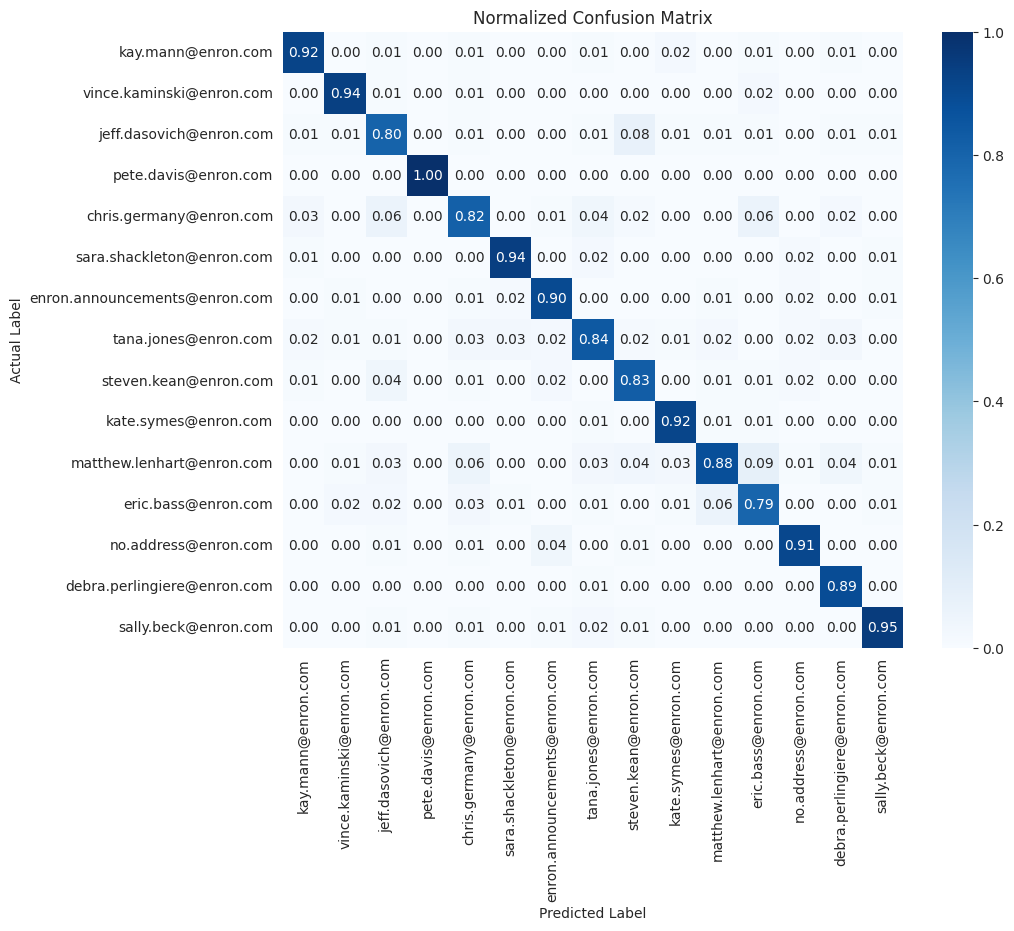

In [ ]:
# Getting sender names
sender_names = senders_list

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=0)  # Note the axis change here

# Plot the heatmap with sender names on both axes
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt=".2f", xticklabels=sender_names, yticklabels=sender_names[::1])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Normalized Confusion Matrix')
plt.show()

Lets see which senders are most often confused

In [ ]:
cl = []
for row in cm.index:
    for col in cm.columns:
        cl.append([cm.loc[col, row], row, col])

cl = pd.DataFrame(cl, columns=['Confusions', 'Predicted', 'Actual']).sort_values(by='Confusions', ascending=False)
cl = cl.query('`Predicted`!=`Actual`').reset_index(drop=True)
cl.head()

,Confusions,Predicted,Actual
0,9.0,eric.bass@enron.com,matthew.lenhart@enron.com
1,8.0,steven.kean@enron.com,jeff.dasovich@enron.com
2,6.0,chris.germany@enron.com,matthew.lenhart@enron.com
3,6.0,jeff.dasovich@enron.com,chris.germany@enron.com
4,6.0,matthew.lenhart@enron.com,eric.bass@enron.com


checking if these relations are symmetric

In [ ]:
cl['Reverse'] = cl.apply(lambda x: cl.query('`Predicted`==@x.Actual & `Actual`==@x.Predicted').values[0][0] , axis=1)
cl.iloc[:15]

,Confusions,Predicted,Actual,Reverse
0,9.0,eric.bass@enron.com,matthew.lenhart@enron.com,6.0
1,8.0,steven.kean@enron.com,jeff.dasovich@enron.com,4.0
2,6.0,chris.germany@enron.com,matthew.lenhart@enron.com,0.0
3,6.0,jeff.dasovich@enron.com,chris.germany@enron.com,1.0
4,6.0,matthew.lenhart@enron.com,eric.bass@enron.com,9.0
5,6.0,eric.bass@enron.com,chris.germany@enron.com,3.0
6,4.0,tana.jones@enron.com,chris.germany@enron.com,3.0
7,4.0,enron.announcements@enron.com,no.address@enron.com,2.0
8,4.0,debra.perlingiere@enron.com,matthew.lenhart@enron.com,0.0
9,4.0,jeff.dasovich@enron.com,steven.kean@enron.com,8.0
